<h1> <b> Task: Data Preparation, Feature Engineering, and Modeling Using the Bank Marketing Dataset </b> </h1>

# Load Python Libraries

In [6]:
pip install ucimlrepo plotly ctgan shap streamlit fairlearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.1/234.1 kB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 56.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 72.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using ca

In [54]:
# Import All Libraries

# GENERAL
import sys
from packaging import version
import uuid
import multiprocessing

# DATA
import numpy as np
import pandas as pd

# VISULISATION
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go


# Data Repository
from ucimlrepo import fetch_ucirepo

# MACHINE LEARNING

# Scikitlearn
import sklearn
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier, IsolationForest
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix, auc, log_loss, accuracy_score, make_scorer, average_precision_score, mean_squared_error, precision_score
from sklearn.neighbors import LocalOutlierFactor
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.utils.class_weight import compute_sample_weight


from sklearn.base import clone

# XGBoost
import xgboost as xgb
from xgboost import XGBClassifier

# DEEP LEARNING

# Tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop, SGD

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import mixed_precision
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import (
    CategoricalCrossentropy,
    SparseCategoricalCrossentropy,
    BinaryCrossentropy,
)

# Conditional Tabular GANs
from ctgan import CTGAN


# Oversampling
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler

# Hyperparameter Tunning
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

# AI Explainability
import shap

# Deployment
import streamlit as st
import joblib

#Fairness
from fairlearn.metrics import MetricFrame, true_positive_rate, true_negative_rate, false_positive_rate,false_negative_rate,selection_rate,count
from fairlearn.reductions import ExponentiatedGradient, DemographicParity,  EqualizedOdds, TruePositiveRateParity
from fairlearn.postprocessing import ThresholdOptimizer

In [8]:
# Manage Versions

assert sys.version_info >= (3, 7)
assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

In [9]:
#Constants


# Test Ratio = 20%
TEST_PORTION = 0.2

# Random State
RANDOM_STATE = 42

# Target Column
TARGET_COL =  'y'

NR_FOLDS = 10



# Load Data


In [10]:

def load_data_from_uci():

  '''Go to UC Irvine Machine Learning reposity and find the Data Set you like
  https://archive.ics.uci.edu/dataset/2/adult and then use Import
  in Python button and then Copy the Python Code into your Notebook
  to Load the Data
  '''

  # fetch dataset
  bank_marketing = fetch_ucirepo(id=222)

  # data (as pandas dataframes)
  input_features = bank_marketing.data.features
  target_feature = bank_marketing.data.targets
  return input_features, target_feature

input_features, target_feature = load_data_from_uci()

## **4. Construct Data**

After studying the individual features, we apply some log transformation, one-hot encoded some and agglomerate some features to reduce model complexity (to avoid the curse of dimensionality).

In [11]:
def prepare_train_test_data():

  input_features, target_feature = load_data_from_uci()

  Xy = pd.concat([input_features, target_feature], axis = 1)
  Xy['uuid'] = [uuid.uuid4() for _ in range(len(Xy))]
  Xy.drop(columns=["poutcome"], inplace=True)
  Xy.dropna(axis=0, inplace=True)

  Train_Xy, Test_Xy = train_test_split(Xy,
                                      test_size = TEST_PORTION,
                                      stratify=Xy[TARGET_COL],
                                      random_state = RANDOM_STATE)

  Train_Xy_uuid = Train_Xy['uuid']
  Test_Xy_uuid = Test_Xy['uuid']

  return Train_Xy, Test_Xy, Train_Xy_uuid, Test_Xy_uuid


# Determine X and y
def make_x_y(Xy, target_col, drop_col=None):
  """

  Args:
    Xy:
    target_col:

  Returns:

  """
  Xy = Xy.drop(columns = drop_col)
  X = Xy.drop(columns = [target_col])
  y = Xy[target_col]
  return X,y

Train_Xy, Test_Xy, Train_Xy_uuid, Test_Xy_uuid = prepare_train_test_data()

Train_X, Train_y = make_x_y(Xy = Train_Xy, target_col = TARGET_COL, drop_col = ['uuid'])

Test_X, Test_y = make_x_y(Xy = Test_Xy, target_col = TARGET_COL, drop_col = ['uuid'])

Train_X.head()

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous
14898,47,blue-collar,divorced,secondary,no,25,no,yes,cellular,16,jul,81,6,-1,0
30894,40,management,married,secondary,no,99,no,no,cellular,9,feb,15,5,-1,0
21168,59,retired,married,secondary,no,385,no,yes,telephone,14,aug,365,2,-1,0
39353,31,blue-collar,single,secondary,no,707,yes,no,cellular,18,may,52,2,-1,0
45170,19,student,single,primary,no,245,no,no,telephone,10,nov,98,2,110,2


# **Feature Engineering**


In [12]:
# Feature creation and transformation
# data_input['days_since_last_contact_imputed'] = data_input['pdays'].replace(-1, 0)
def map_to_weekday(day):
    return ((day - 1) % 7) + 1

class CustomFeatureCreator(BaseEstimator, TransformerMixin):
    def __init__(self, add_log_transform=True):
        self.add_log_transform = add_log_transform

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Assume X is a DataFrame
        X = X.copy()
        X["duration"] = X["duration"]/60

        X["is_unemployed"] = X["job"].isin(["unemployed", "student", "retired"]).astype(int)
        X["is_married"] = (X["marital"] == "married").astype(int)
        X["day_of_week"] = X["day_of_week"].apply(map_to_weekday).astype(int)
        X["is_weekend"] = X["day_of_week"].isin([6, 7]).astype(int)
        # Map each month to its respective quarter
        month_to_quarter = {
          'jan': '1st quarter', 'feb': '1st quarter', 'mar': '1st quarter',
          'apr': '2nd quarter', 'may': '2nd quarter', 'jun': '2nd quarter',
          'jul': '3rd quarter', 'aug': '3rd quarter', 'sep': '3rd quarter',
          'oct': '4th quarter', 'nov': '4th quarter', 'dec': '4th quarter'
        }

        X['quarter'] = X['month'].map(month_to_quarter)

        bins = [0, 20, 30, 45, 60, np.inf]
        labels = ['<20', '20-30', '30-45', '45-60', '60+']
        X['age_group'] = pd.cut(X['age'], bins=bins, labels=labels, right=False)

        bins = [-float('inf'), -10000, -5000, 0, 20000, 40000, float('inf')]
        labels = ['Extremely Negative','Very Negative', 'Negative', 'Low', 'Medium', 'High']
        # Bin the balance values
        X['balance_group'] = pd.cut(X['balance'], bins=bins, labels=labels, right=False)

        bins = [-1, 0, 200, 400, float('inf')]
        labels = ['Bin1', 'Bin2', 'Bin3', 'Bin4']
        # Bin the balance values
        X['pdays_group'] = pd.cut(X['pdays'], bins=bins, labels=labels, right=False)




        # Adding log transformation for capital-gain
        if self.add_log_transform:
            X['log_duration'] = np.log1p(X['duration'])  # np.log1p is used to handle zero values smoothly
            X["log_campaign"] = np.log1p(X["campaign"])
            X['log_previous'] = np.log1p(X['previous'])  # np.log1p is used to handle zero values smoothly

        return X


num = ["log_campaign", "log_duration", 'log_previous']

# cat = ["education", "default", "housing", "loan", "contact", "month", "day_of_week"]
cat = ["education", "loan", "quarter", 'age_group', 'balance_group', 'pdays_group']

binary_features = ["is_unemployed", "is_married",  "is_weekend"]

drop_feature = ["age", "marital", "education", "default", "housing", "loan", "contact", "month", 'duration', "job", "balance", "pdays", "day_of_week", "previous", "month", "campaign", ]

# feature scaling and encoding

# Setting up ColumnTransformer

feature_transformer = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num), # scaling numerical input variables
        ('cat', OneHotEncoder(sparse_output=False, drop="first"), cat), # encoding categorical input variables
        ('binary', 'passthrough', binary_features), # skip these features
        ('transformed', 'drop', drop_feature) # drop these features
    ],
    remainder='passthrough'
)

# feature_transformer = ColumnTransformer(
#     transformers=[
#         ('num', StandardScaler(), num), # scaling numerical input variables
#         ('preprocessor', PolynomialFeatures(degree=2, include_bias=False), num),
#         ('cat', OneHotEncoder(sparse_output=False, drop="first"), cat), # encoding categorical input variables
#         ('binary', 'passthrough', binary_features), # skip these features
#         ('transformed', 'drop', drop_feature) # drop these features
#     ],
#     remainder='passthrough'
# )

# Feature Engineering
feature_engineering_pipeline = Pipeline(steps=[
    ('feature_creation', CustomFeatureCreator()), # create feature
    ('feature_transform', feature_transformer) # transform features
])



# Apply the feature engineering pipeline
feature_engineering_pipeline.fit(Train_X)
label_encoder = LabelEncoder().fit(Train_y)

Train_X_transformed = feature_engineering_pipeline.transform(Train_X)
Train_y_transformed = label_encoder.transform(Train_y)

Test_X_transformed = feature_engineering_pipeline.transform(Test_X)
Test_y_transformed = label_encoder.transform(Test_y)


In [ ]:
Train_X_transformed.shape, Test_X_transformed.shape, Train_y_transformed.shape, Test_y_transformed.shape

((24725, 23), (6182, 23), (24725,), (6182,))

In [8]:
feature_transformer.get_feature_names_out()

array(['num__log_campaign', 'num__log_duration', 'num__log_previous',
       'cat__education_secondary', 'cat__education_tertiary',
       'cat__loan_yes', 'cat__quarter_2nd quarter',
       'cat__quarter_3rd quarter', 'cat__quarter_4th quarter',
       'cat__age_group_30-45', 'cat__age_group_45-60',
       'cat__age_group_60+', 'cat__age_group_<20',
       'cat__balance_group_Low', 'cat__balance_group_Medium',
       'cat__balance_group_Negative', 'cat__balance_group_Very Negative',
       'cat__pdays_group_Bin2', 'cat__pdays_group_Bin3',
       'cat__pdays_group_Bin4', 'binary__is_unemployed',
       'binary__is_married', 'binary__is_weekend'], dtype=object)

# **Modelling Part I**
1. Select Modelling Technique
2. Build Model
3. Assess Model
4. Feature Evaluation & Selection


## **1.Select Modelling Technique**

Different models have their strengths and weakness hence different models will be explored. As argued in the lecture notes, random forest will be chosen as a base model for its robustness, versatility, and generally high performance across a wide range of data types and tasks.

## **2. Build Model**
### **2.1 Logistic Regression**

In [9]:
log_reg_model = LogisticRegression(random_state=42, max_iter=1000)

log_reg_model.fit(Train_X_transformed, Train_y_transformed)



LogisticRegression(max_iter=1000, random_state=42)

### **2.2 Random Forest**

In [10]:
rf_model = RandomForestClassifier(random_state=42)

rf_model.fit(Train_X_transformed, Train_y_transformed)

RandomForestClassifier(random_state=42)

## **3. Assess Model**

### **3.1 Random Forest Model**
The model performs bad on the minority class, hence we apply some solution for treatment of imbalance classes.

In [11]:
# Predictions
y_pred2 = rf_model.predict(Test_X_transformed)
y_proba2 = rf_model.predict_proba(Test_X_transformed)

TARGET_NAMES = Train_y.unique().tolist()
print(classification_report(Test_y_transformed, y_pred2, target_names=TARGET_NAMES))

              precision    recall  f1-score   support

          no       0.90      0.94      0.92      5279
         yes       0.50      0.37      0.42       903

    accuracy                           0.85      6182
   macro avg       0.70      0.65      0.67      6182
weighted avg       0.84      0.85      0.84      6182



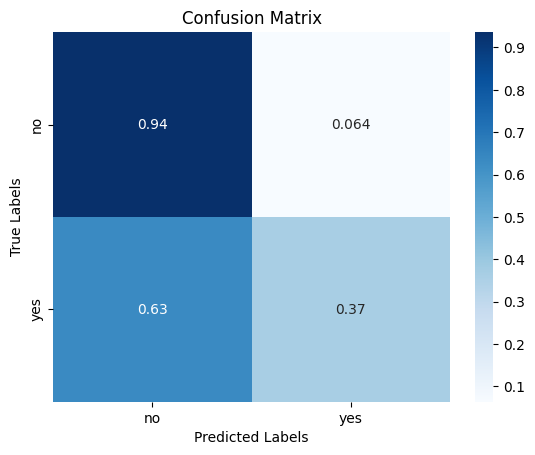

In [12]:
# gives the breakdown of the above result into tp, tn, fp, and fn as seen in the heatmap below
cm = confusion_matrix(Test_y_transformed, y_pred2, normalize='true')
tot = cm.sum()
# cm= cm/tot
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=TARGET_NAMES, yticklabels=TARGET_NAMES)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

### **3.2 Logistic Regression**

In [13]:
# Predictions
y_pred = log_reg_model.predict(Test_X_transformed)
y_proba = log_reg_model.predict_proba(Test_X_transformed)

TARGET_NAMES = Train_y.unique().tolist()
print(classification_report(Test_y_transformed, y_pred, target_names=TARGET_NAMES))

              precision    recall  f1-score   support

          no       0.89      0.97      0.93      5279
         yes       0.62      0.30      0.41       903

    accuracy                           0.87      6182
   macro avg       0.76      0.64      0.67      6182
weighted avg       0.85      0.87      0.85      6182



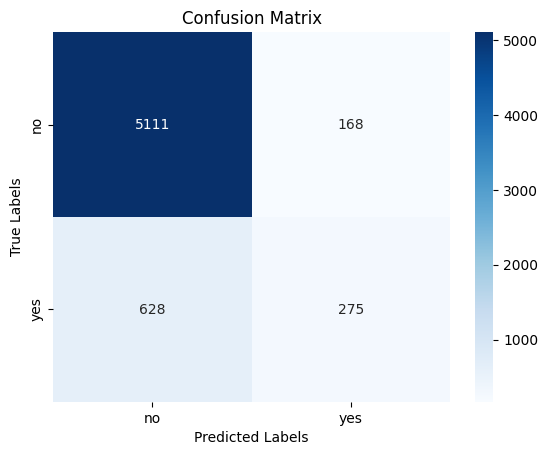

In [14]:
# gives the breakdown of the above result into tp, tn, fp, and fn as seen in the heatmap below
cm = confusion_matrix(Test_y_transformed, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=TARGET_NAMES, yticklabels=TARGET_NAMES)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

## **4. Cross Validation**



In [15]:
# Apply 10-fold cross-validation
skf = StratifiedKFold(n_splits = 10,
                     shuffle = True,
                     random_state = RANDOM_STATE)
cv_scores = cross_val_score(rf_model, Train_X_transformed, Train_y_transformed, cv=skf, scoring='f1_weighted')

# Print the results of the cross-validation
print("CV Scores for each fold: \n", cv_scores)
print("\nAverage CV Score:\n", cv_scores.mean())

CV Scores for each fold: 
 [0.84462212 0.84138971 0.84977633 0.84683603 0.83692562 0.83977691
 0.84686022 0.83983384 0.85085594 0.83724491]

Average CV Score:
 0.8434121626668695


In [ ]:
# Apply 10-fold cross-validation
cv_scores = cross_val_score(log_reg_model, Train_X_transformed, Train_y_transformed, cv=skf, scoring='f1_weighted')

# Print the results of the cross-validation
print("CV Scores for each fold: \n", cv_scores)
print("\nAverage CV Score:\n", cv_scores.mean())

CV Scores for each fold: 
 [0.83964235 0.85058155 0.84808557 0.85236763 0.85370328 0.83660294
 0.84273253 0.84799397 0.84242998 0.8422906 ]

Average CV Score:
 0.8456430389883096


## **4. Feature Selection/Importance**

Here, instead of removing less important features, we will apply some regularization or do PCA in a later stage so the model generalises better

In [16]:
rf_model.feature_importances_

array([8.44611517e-02, 5.67018759e-01, 6.51173294e-02, 1.74934958e-02,
       1.82114502e-02, 1.64852289e-02, 1.85419686e-02, 2.25177179e-02,
       1.65185750e-02, 2.09427454e-02, 1.77287578e-02, 1.52305423e-02,
       9.20399234e-04, 4.60164803e-03, 1.60767349e-03, 4.07675572e-03,
       1.20715013e-06, 2.34903238e-02, 9.60359980e-03, 7.37615910e-03,
       1.73104537e-02, 2.42099721e-02, 2.65340861e-02])

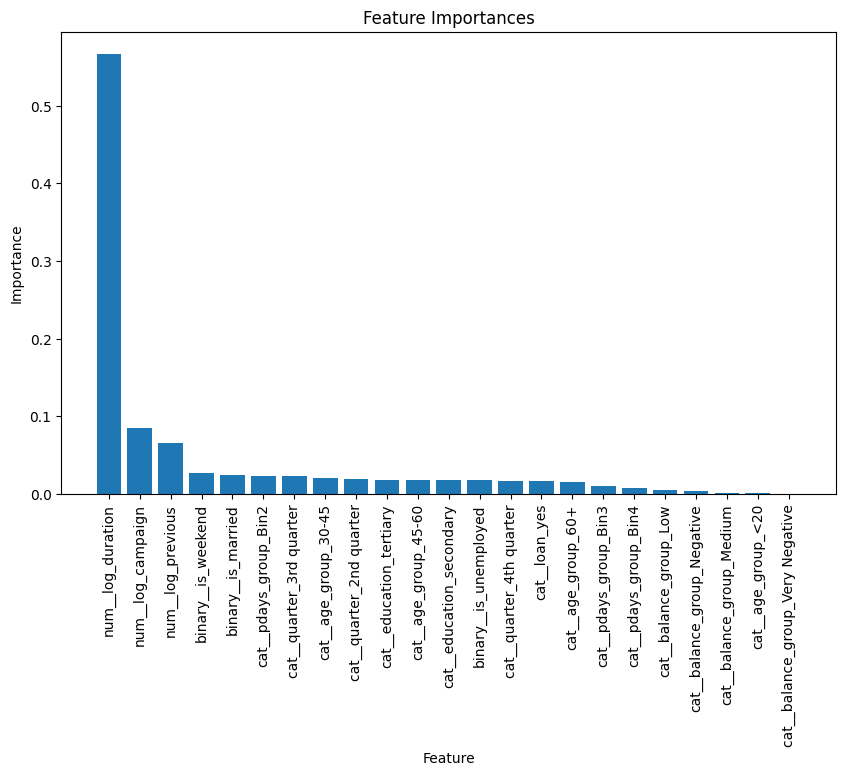

In [17]:

# Get feature importances
importances = rf_model.feature_importances_

# If using ColumnTransformer or Pipeline, ensure you adjust this part to accurately reflect feature names.
# Here is an example assuming you know the feature names:
feature_names = feature_transformer.get_feature_names_out()  # Replace with your actual feature names

# Sort feature importances in descending order and create labels
indices = np.argsort(importances)[::-1]
sorted_feature_names = [feature_names[idx] for idx in indices]
sorted_importances = importances[indices]

# Create the plot
plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.bar(range(len(sorted_importances)), sorted_importances, align='center')
plt.xticks(range(len(sorted_importances)), sorted_feature_names, rotation=90)
# plt.yscale("log")

plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()


# **Modelling Part II**

## **Comparison of Different Models using Cross-Validation for the Original Unbalance Dataset**

Here we used AUPRC metrics for evaluating the dataset because of its unbalanced nature

In [ ]:
# Setting up models
models = {
    'Naive Bayes': GaussianNB(),
    'Logistic Regression': LogisticRegression(class_weight='balanced', solver='saga', max_iter=200, random_state=42),
    'Decision Tree': DecisionTreeClassifier(class_weight='balanced', random_state=42),
    'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(scale_pos_weight=sum(Train_y_transformed == 0) / sum(Train_y_transformed == 1),random_state=42),  # XGBoost handles imbalance by scale_pos_weight
    'Extra Trees': ExtraTreesClassifier(class_weight='balanced', random_state=42),
    'AdaBoost': AdaBoostClassifier(estimator=DecisionTreeClassifier(class_weight='balanced',random_state=42)),
    'BaggingClassifier': BaggingClassifier(estimator=ExtraTreeClassifier(random_state=42), n_estimators=100)
}

# Scorer for cross-validation: Area Under Precision-Recall Curve (AUPRC)
auprc_scorer = make_scorer(average_precision_score,
                           needs_proba=True)

# Perform cross-validation and store results
results = {}
skf = StratifiedKFold(n_splits = NR_FOLDS,
                     shuffle = True,
                     random_state = RANDOM_STATE)

for name, model in models.items():
    scores = cross_val_score(model,
                             Train_X_transformed,
                             Train_y_transformed,
                             cv = skf,
                             scoring = auprc_scorer)
    results[name] = np.mean(scores)
    print(f"{name}: Mean AUPRC = {results[name]:.4f}")

# Comparing models
best_model = max(results, key=results.get)
print(f"Best model based on AUPRC: {best_model} with an AUPRC of {results[best_model]:.4f}")


Naive Bayes: Mean AUPRC = 0.3632
Logistic Regression: Mean AUPRC = 0.4910
Decision Tree: Mean AUPRC = 0.2389
Random Forest: Mean AUPRC = 0.4351
Gradient Boosting: Mean AUPRC = 0.5212
XGBoost: Mean AUPRC = 0.4981
Extra Trees: Mean AUPRC = 0.3649
AdaBoost: Mean AUPRC = 0.3359
BaggingClassifier: Mean AUPRC = 0.4254
Best model based on AUPRC: Gradient Boosting with an AUPRC of 0.5212


Below we visualize the various model performance using the average cross validation auprc score. it is clear that the gradiant boosting model is the best performing model with auprc score of $52\%$. This will be use as our benchmark/baseline peformance metric.

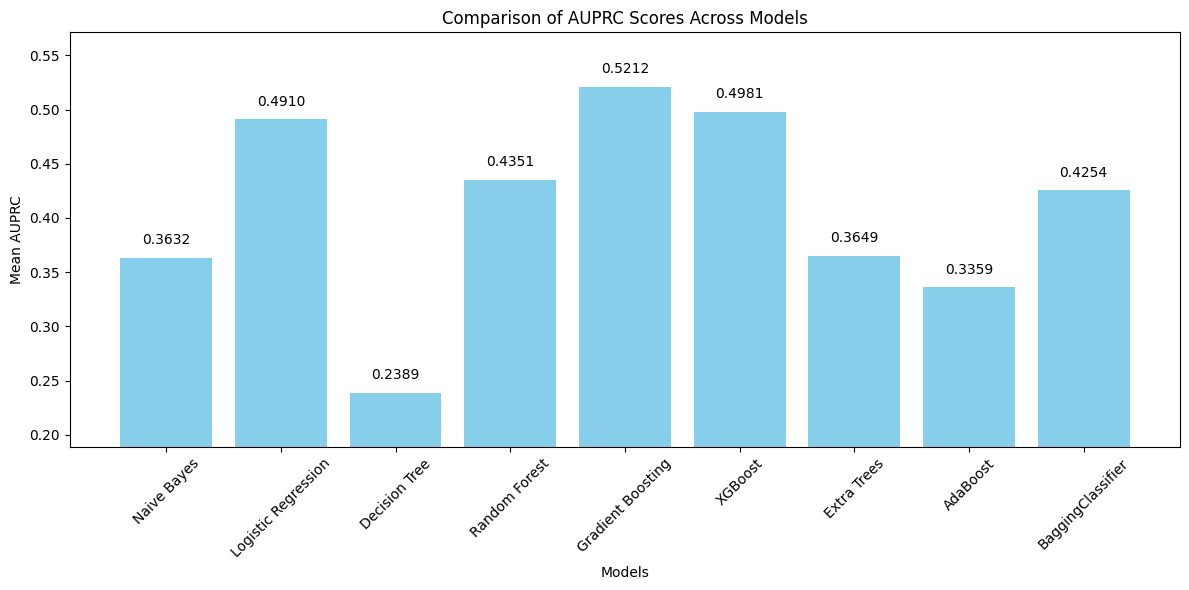

In [ ]:
# Names of the models
model_names = list(results.keys())
# AUPRC scores
auprc_scores = [results[name] for name in model_names]

# Creating the bar plot
plt.figure(figsize=(12, 6))
plt.bar(model_names, auprc_scores, color='skyblue')
plt.xlabel('Models')
plt.ylabel('Mean AUPRC')
plt.title('Comparison of AUPRC Scores Across Models')
plt.xticks(rotation=45)
plt.ylim([min(auprc_scores) - 0.05, max(auprc_scores) + 0.05])  # Set y-axis limits to give some padding

# Adding the score above each bar
for i, v in enumerate(auprc_scores):
    plt.text(i, v + 0.01, f"{v:.4f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()


## **Precision-recall curve**

In [ ]:
# Dictionary to store precision and recall values for each model
precision_recall_data = {}

# Setup cross-validation
skf = StratifiedKFold(n_splits=NR_FOLDS, shuffle=True, random_state=RANDOM_STATE)

for name, model in models.items():
    model_precisions = []
    model_recalls = []
    model_thresholds = []
    for train_index, val_index in skf.split(Train_X_transformed, Train_y_transformed):
        X_train, X_val = Train_X_transformed[train_index], Train_X_transformed[val_index]
        y_train, y_val = Train_y_transformed[train_index], Train_y_transformed[val_index]

        cloned_model = clone(model)
        cloned_model.fit(X_train, y_train)
        y_scores = cloned_model.predict_proba(X_val)[:, 1]

        precision, recall, thresholds = precision_recall_curve(y_val, y_scores)
        model_precisions.append(precision)
        model_recalls.append(recall)
        model_thresholds.append(thresholds)

    # Average precision and recall over folds
    mean_precision = np.mean([np.interp(np.linspace(0, 1, 100), np.sort(r), p[np.argsort(r)]) for p, r in zip(model_precisions, model_recalls)], axis=0)
    mean_recall = np.linspace(0, 1, 100)
    precision_recall_data[name] = (mean_precision, mean_recall)

# Compute AUC PR for each model
from sklearn.metrics import auc
model_auc_pr = {name: auc(recall, precision) for name, (precision, recall) in precision_recall_data.items()}


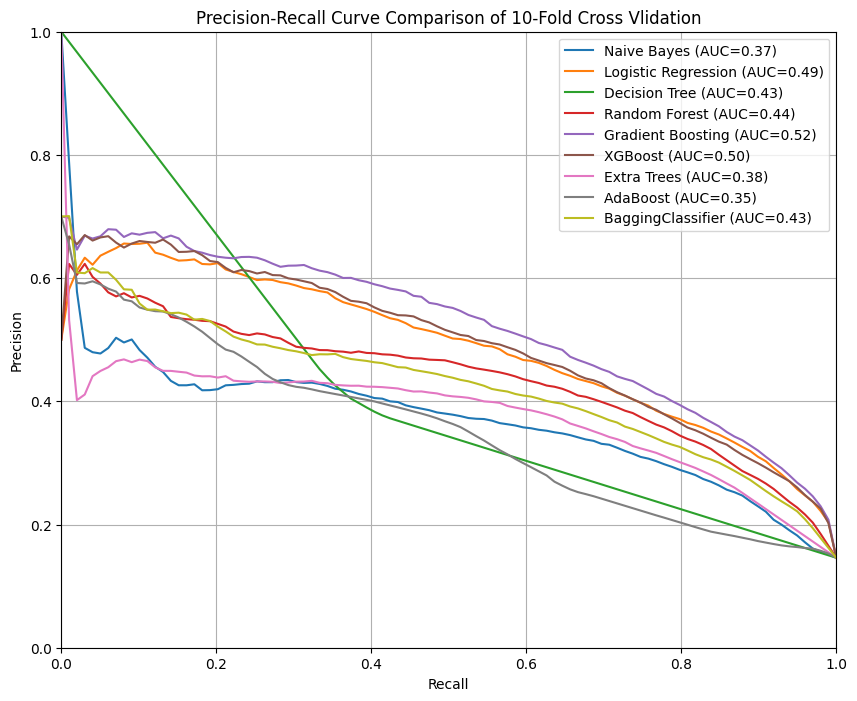

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
for name, (precision, recall) in precision_recall_data.items():
    plt.plot(recall, precision, label=f'{name} (AUC={model_auc_pr[name]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve Comparison of 10-Fold Cross Vlidation')
plt.legend(loc='upper right')
plt.grid(True)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()


## **Gradient Boosting**
This is the best performing model
#### **Build Final model on the Unbalanced Dataset**

In [18]:
final_model = GradientBoostingClassifier()
final_model.fit(Train_X_transformed, Train_y_transformed)


GradientBoostingClassifier()

In [19]:
# Custom AUPRC evaluation metric
def auprc_score(y_true, y_pred):
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    return auc(recall, precision)

from sklearn.model_selection import cross_val_predict

## Get the predictions
y_pred_proba = cross_val_predict(final_model, Train_X_transformed, Train_y_transformed, method='predict_proba', cv=10)[:, 1]

# Calculate the AUPRC
auprc = auprc_score(Train_y_transformed, y_pred_proba)
print(f'Final Model AUPRC: {auprc:.4f}')

# Predict probabilities on the evaluation set
# y_pred = final_model.predict_proba(Train_X_transformed)[:, 1]

# # Calculate the AUPRC score
# auprc = auprc_score(Train_y_transformed, y_pred)
# print(f'AUPRC: {auprc}')


Final Model AUPRC: 0.5183


## **Checking Overfitting/Underfitting**

#### **Learning Curves**
There is no sign of overfitting here.

**NB:**

**Overfitting:** The training loss will decrease significantly while the validation loss starts to increase or stagnate after some point.

**Underfitting:** Both training and validation losses are high and do not decrease significantly over time.

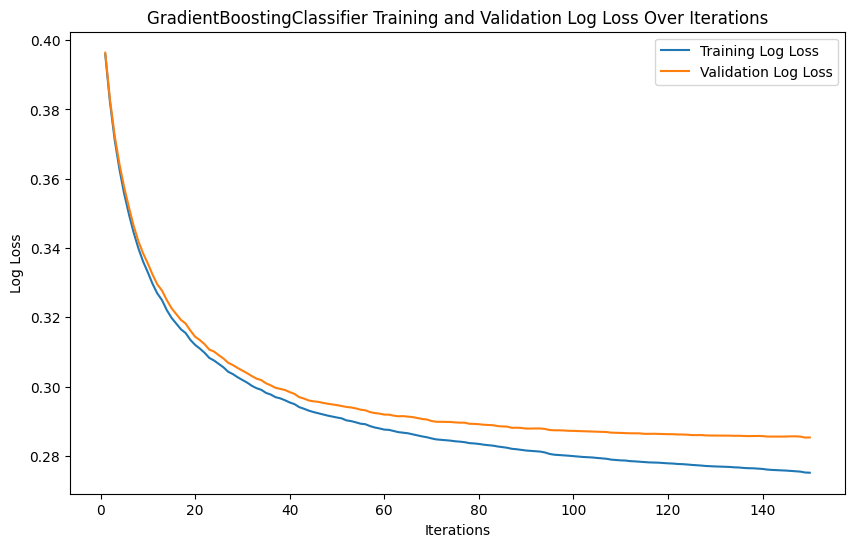

In [ ]:
def fit_and_track_gbc(X_train, y_train, X_val, y_val, num_rounds=150):
    model = GradientBoostingClassifier(n_estimators=num_rounds, loss='log_loss')

    train_logloss = []
    val_logloss = []

    for i in range(1, num_rounds + 1):
        model.n_estimators = i
        model.fit(X_train, y_train)

        y_train_pred = model.predict_proba(X_train)[:, 1]
        y_val_pred = model.predict_proba(X_val)[:, 1]

        train_logloss.append(log_loss(y_train, y_train_pred))
        val_logloss.append(log_loss(y_val, y_val_pred))

    return train_logloss, val_logloss

X_train, X_val, y_train, y_val = train_test_split(Train_X_transformed, Train_y_transformed, stratify=Train_y_transformed, random_state=42, test_size=0.2)

# Assuming X_train, y_train, X_val, y_val have been defined
train_logloss, val_logloss = fit_and_track_gbc(X_train, y_train, X_val, y_val)

# Plotting
iterations = range(1, len(train_logloss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(iterations, train_logloss, label='Training Log Loss')
plt.plot(iterations, val_logloss, label='Validation Log Loss')
plt.title('GradientBoostingClassifier Training and Validation Log Loss Over Iterations')
plt.xlabel('Iterations')
plt.ylabel('Log Loss')
plt.legend()
plt.show()

#### **Error vs Complexity**
Another techique to check for the overfitting and underfitting is looking at the error variation with increasing model complexity.

**NB:**

**Overfitting:** Low training error and high validation error.

**Underfitting:** High training error and high validation error

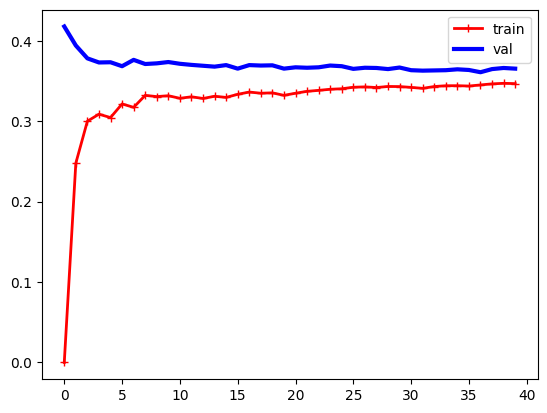

In [ ]:
def plot_learning_curves(model, X_train, y_train, X_val, y_val):
  train_errors, val_errors = [], []

  for m in range(200, len(X_train), 500):
    model.fit(X_train[:m], y_train[:m])
    y_train_predict = model.predict(X_train[:m])
    y_val_predict = model.predict(X_val)
    train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
    val_errors.append(mean_squared_error(y_val, y_val_predict))

  plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
  plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
  plt.legend()
  plt.show()

X_train, X_val, y_train, y_val = train_test_split(Train_X_transformed, Train_y_transformed, stratify=Train_y_transformed, random_state=42, test_size=0.2)

model = GradientBoostingClassifier()
plot_learning_curves(model, X_train, y_train, X_val, y_val)

#### **Feature Importance/Selection for Final model on the Unbalanced Dataset**

The plot below shows the feature importance in descending order with the most important feature being duration (log tranformed to capture the intrinsic normality bias of most models particularly linear models)

Feature Importances:
Feature: num__log_campaign, Importance: 0.016989064852149727
Feature: num__log_duration, Importance: 0.637746422279692
Feature: num__log_previous, Importance: 0.027574976514273618
Feature: cat__education_secondary, Importance: 0.0017652285344488823
Feature: cat__education_tertiary, Importance: 0.019416260320955867
Feature: cat__loan_yes, Importance: 0.018255216527709416
Feature: cat__quarter_2nd quarter, Importance: 0.002322176106334736
Feature: cat__quarter_3rd quarter, Importance: 0.02964652719932172
Feature: cat__quarter_4th quarter, Importance: 0.004338843560359321
Feature: cat__age_group_30-45, Importance: 0.008029847988708955
Feature: cat__age_group_45-60, Importance: 0.01083673118311445
Feature: cat__age_group_60+, Importance: 0.04133691813928688
Feature: cat__age_group_<20, Importance: 0.0010144031908711096
Feature: cat__balance_group_Low, Importance: 0.0
Feature: cat__balance_group_Medium, Importance: 0.0008875731790335508
Feature: cat__balance_group_Negat

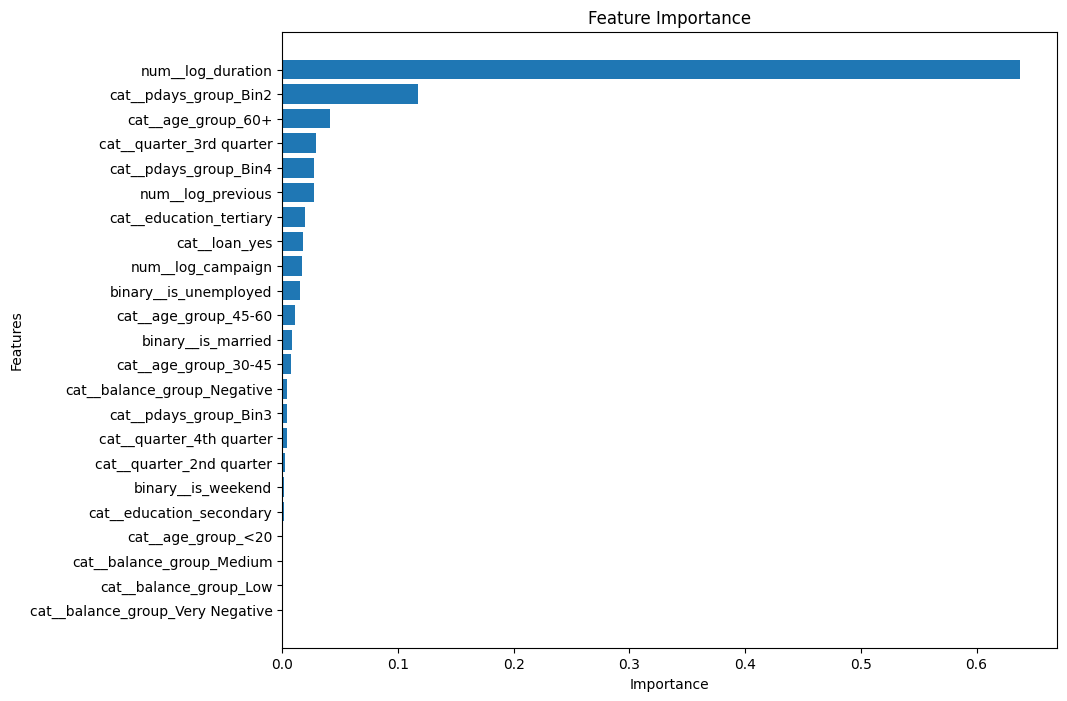

In [ ]:
import matplotlib.pyplot as plt
feature_names = feature_transformer.get_feature_names_out().tolist()

# Extract feature importances
feature_importances = final_model.feature_importances_

# Create a dictionary mapping feature names to their importance
feature_importances_dict = {name: importance for name, importance in zip(feature_names, feature_importances)}

# Print the feature importance
print("Feature Importances:")
for feature, importance in feature_importances_dict.items():
    print(f"Feature: {feature}, Importance: {importance}")

# Sorting the features based on importance
sorted_importances = sorted(feature_importances_dict.items(), key=lambda x: x[1], reverse=True)
features, importances = zip(*sorted_importances)

# Creating a bar chart
plt.figure(figsize=(10, 8))
plt.barh(features, importances)
plt.xlabel("Importance")
plt.ylabel("Features")
plt.title("Feature Importance")
plt.gca().invert_yaxis()  # Invert the Y-axis to show the most important feature at the top
plt.show()

## **Gradient Boosting + Imbalanced Data Solution - Oversampling (CTGAN, SMOTE, ADASYN) and Undersampling**

Using the best performing model, gradient boosting which we earlier showed has a performance of $52\%$ (auprc score) on the unbalanced dataset. Here we explore unbalance data solutions and we saw an improvement. By over-sampling with CTGAN gives the best auprc score of $96.9\%$ as against the $52\%$ score of the original unbalanced dataset.

In [13]:
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc
from sklearn.model_selection import StratifiedKFold, cross_val_score
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
import numpy as np
import pandas as pd

# Function to apply CTGAN oversampling
def apply_ctgan(X_train, y_train):

    # CTGAN model for oversampling
    ctgan = CTGAN(epochs=5)

    # Convert training data to DataFrame
    df_train = pd.DataFrame(X_train, columns=[f'feature_{i}' for i in range(X_train.shape[1])])
    df_train['target'] = y_train

    # Identify the majority and minority classes
    majority_class = 0
    minority_class = 1

    # Fit CTGAN on the entire training data (if required, can also fit only on majority to enforce learning only majority patterns)
    ctgan.fit(df_train, discrete_columns=['target'])

    # Calculate the number of synthetic samples needed to balance or meet a specific target ratio
    majority_count = sum(y_train == majority_class)
    minority_count = sum(y_train == minority_class)
    synthetic_count = majority_count - minority_count  # Adjust this logic as needed for your specific balancing goals

    # Generate synthetic samples
    synthetic_data = ctgan.sample(synthetic_count)

    # Filter to ensure only minority class samples are used if necessary
    synthetic_minority = synthetic_data[synthetic_data['target'] == minority_class]

    # If synthetic_minority is still too large or small, adjust the count again
    adjustment_count = synthetic_count - len(synthetic_minority)
    if adjustment_count > 0:
        additional_synthetic = ctgan.sample(adjustment_count)
        additional_synthetic_minority = additional_synthetic[additional_synthetic['target'] == minority_class]
        synthetic_minority = pd.concat([synthetic_minority, additional_synthetic_minority])

    # Combine the original training data with the synthetic minority class data
    synthetic_data_X = synthetic_minority.drop('target', axis=1).values
    synthetic_data_y = synthetic_minority['target'].values
    X_train_ctgan = np.vstack((X_train, synthetic_data_X))
    y_train_ctgan = np.hstack((y_train, synthetic_data_y))

    return X_train_ctgan, y_train_ctgan

def apply_undersampling(X, y):
    rus = RandomUnderSampler(random_state=42)
    X_res, y_res = rus.fit_resample(X, y)
    return X_res, y_res

def apply_smote(X, y):
    smote = SMOTE(random_state=42)
    X_res, y_res = smote.fit_resample(X, y)
    return X_res, y_res

def apply_adasyn(X, y):
    adasyn = ADASYN(random_state=42)
    X_res, y_res = adasyn.fit_resample(X, y)
    return X_res, y_res


# this is the same as average_precision_score
def auprc_score(y_true, y_pred):
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    return auc(recall, precision)


# Make scorer for use in cross-validation
auprc_scorer = make_scorer(auprc_score, needs_proba=True)


# Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Function to evaluate models with different sampling techniques
def evaluate_model(model, X, y):
    scores = cross_val_score(model, X, y, cv=skf, scoring=auprc_scorer)
    return scores


In [21]:

# Base Gradient Boosting model
gb_model = GradientBoostingClassifier()

# 1. Gradient Boosting with SMOTE
Train_X_smote, Train_y_smote = apply_smote(Train_X_transformed, Train_y_transformed)
cv_scores_gb_smote = evaluate_model(gb_model, Train_X_smote, Train_y_smote)
print(f'Gradient Boosting + SMOTE AUPRC Scores: {cv_scores_gb_smote}')
print(f'Mean AUPRC Score Gradient Boosting + SMOTE: {cv_scores_gb_smote.mean()}')

# Base Gradient Boosting model
gb_model = GradientBoostingClassifier()

# 2. Gradient Boosting with ADASYN
Train_X_adasyn, Train_y_adasyn = apply_adasyn(Train_X_transformed, Train_y_transformed)
cv_scores_gb_adasyn = evaluate_model(gb_model, Train_X_adasyn, Train_y_adasyn)
print(f'Gradient Boosting + ADASYN AUPRC Scores: {cv_scores_gb_adasyn}')
print(f'Mean AUPRC Score Gradient Boosting + ADASYN: {cv_scores_gb_adasyn.mean()}')

# Base Gradient Boosting model
gb_model = GradientBoostingClassifier()

# 3. Gradient Boosting with Random Undersampling
Train_X_undersample, Train_y_undersample = apply_undersampling(Train_X_transformed, Train_y_transformed)
cv_scores_gb_undersample = evaluate_model(gb_model, Train_X_undersample, Train_y_undersample)
print(f'Gradient Boosting + Random Undersampling AUPRC Scores: {cv_scores_gb_undersample}')
print(f'Mean AUPRC Score Gradient Boosting + Random Undersampling: {cv_scores_gb_undersample.mean()}')

# Base Gradient Boosting model
gb_model = GradientBoostingClassifier()

# 4. Only Gradient Boosting with Original Data
cv_scores_gb = evaluate_model(gb_model, Train_X_transformed, Train_y_transformed)
print(f'Gradient Boosting All Data AUPRC Scores: {cv_scores_gb}')
print(f'Mean AUPRC Score Gradient Boosting ALL Data: {cv_scores_gb.mean()}')

# Base Gradient Boosting model
gb_model = GradientBoostingClassifier()

# 5. Gradient Boosting with CTGAN
Train_X_ctgan, Train_y_ctgan = apply_ctgan(Train_X_transformed, Train_y_transformed)
cv_scores_gb_ctgan = evaluate_model(gb_model, Train_X_ctgan, Train_y_ctgan)
print(f'Gradient Boosting + CTGAN AUPRC Scores: {cv_scores_gb_ctgan}')
print(f'Mean AUPRC Score Gradient Boosting + CTGAN: {cv_scores_gb_ctgan.mean()}')

# Select the best performing model configuration
best_model_type = max(
    [('SMOTE', cv_scores_gb_smote.mean()),
     ('ADASYN', cv_scores_gb_adasyn.mean()),
     ('CTGAN', cv_scores_gb_ctgan.mean()),
     ('Undersample', cv_scores_gb_undersample.mean()),
     ('ALL', cv_scores_gb.mean())],
    key=lambda x: x[1]
)[0]

print(f'Best Model Type: {best_model_type}')

# Set the best training data based on the best model type
if best_model_type == 'ALL':
    print('Best Model is ALL Data')
    best_X_train, best_y_train = Train_X_transformed, Train_y_transformed
elif best_model_type == 'SMOTE':
    print('Best Model is SMOTE')
    best_X_train, best_y_train = Train_X_smote, Train_y_smote
elif best_model_type == 'ADASYN':
    print('Best Model is ADASYN')
    best_X_train, best_y_train = Train_X_adasyn, Train_y_adasyn
elif best_model_type == 'CTGAN':
  print('Best Model is CTGAN')
  best_X_train, best_y_train = Train_X_ctgan, Train_y_ctgan
else:
    print('Best Model is UnderSampled')
    best_X_train, best_y_train = Train_X_undersample, Train_y_undersample




Gradient Boosting + SMOTE AUPRC Scores: [0.93683202 0.93687982 0.9356039  0.93510852 0.93684151 0.93380134
 0.9364548  0.9310164  0.93194176 0.93454349]
Mean AUPRC Score Gradient Boosting + SMOTE: 0.9349023549845887
Gradient Boosting + ADASYN AUPRC Scores: [0.93199781 0.93339302 0.93444342 0.93243101 0.93385224 0.93182596
 0.93104329 0.9217868  0.92634502 0.9283055 ]
Mean AUPRC Score Gradient Boosting + ADASYN: 0.930542405178428
Gradient Boosting + Random Undersampling AUPRC Scores: [0.85386482 0.8494359  0.87483763 0.84133942 0.87595186 0.83635328
 0.85877782 0.83644131 0.8345578  0.84706429]
Mean AUPRC Score Gradient Boosting + Random Undersampling: 0.8508624138201533
Gradient Boosting All Data AUPRC Scores: [0.51139328 0.53590578 0.532264   0.55083323 0.52738042 0.48545191
 0.52691563 0.50286758 0.51403351 0.50728842]
Mean AUPRC Score Gradient Boosting ALL Data: 0.5194333731480106


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Gradient Boosting + CTGAN AUPRC Scores: [0.96966844 0.96801066 0.96809707 0.96997992 0.96900868 0.97260005
 0.9722547  0.97127647 0.96875062 0.96986115]
Mean AUPRC Score Gradient Boosting + CTGAN: 0.9699507759785622
Best Model Type: CTGAN
Best Model is CTGAN


### **2.Hyperparameter Tunning with Hyperopt for Gradient Boosting with CTGAN**

Can the performance be again improved if optimise the hyperparameters of the model as we currently have the out-of-box performance.Using the balanced dataset from CTGAN, we performed a bayesian hyperparameter search for the optimised parameters and we got a new performance of $97\%$ (corresponds $0.1\%$ increase without optimisation).

In [22]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)


# Define the objective function for hyperparameter tuning
def objective(params):
    model = GradientBoostingClassifier(
        n_estimators=int(params['n_estimators']),
        max_depth=int(params['max_depth']),
        learning_rate=params['learning_rate'],
        subsample=params['subsample'],
        max_features=params['max_features'],
        random_state=42
    )
    score = cross_val_score(model,
                            best_X_train,
                            best_y_train,
                            cv=skf, scoring=auprc_scorer).mean()
    return {'loss': -score, 'status': STATUS_OK}


# Define the hyperparameter space
param_space = {
    'n_estimators': hp.quniform('n_estimators', 50, 300, 10),
    'max_depth': hp.quniform('max_depth', 3, 15, 1),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'subsample': hp.uniform('subsample', 0.7, 1.0),
    'max_features': hp.uniform('max_features', 0.7, 1.0)
}

# Initialize Trials object
trials = Trials()

# Optimize hyperparameters using Hyperopt
best_params = fmin(fn=objective,
                   space=param_space,
                   algo=tpe.suggest,
                   max_evals=25,
                   trials=trials)

# Convert hyperparameters to correct types
best_params['n_estimators'] = int(best_params['n_estimators'])
best_params['max_depth'] = int(best_params['max_depth'])
print(f'Best Hyperparameters: {best_params}')


# Final model with best hyperparameters
final_model = GradientBoostingClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],
    subsample=best_params['subsample'],
    max_features=best_params['max_features'],
    random_state=42
)

# Evaluate final model using stratified cross-validation
final_cv_scores = evaluate_model(final_model, best_X_train, best_y_train)
print(f'Final Model 10-Fold Cross-Validation AUPRC Scores: {final_cv_scores}')
print(f'Mean AUPRC Score: {final_cv_scores.mean()}')


100%|██████████| 25/25 [36:36<00:00, 87.84s/trial, best loss: -0.9703405505179666]
Best Hyperparameters: {'learning_rate': 0.05450375470155411, 'max_depth': 5, 'max_features': 0.8690318983439111, 'n_estimators': 250, 'subsample': 0.7722300635823657}
Final Model 10-Fold Cross-Validation AUPRC Scores: [0.96987286 0.97094589 0.9702029 ]
Mean AUPRC Score: 0.9703405505179666


### **3. Build Gradient Boosting Final Model**

Built using the best hyper-parameters

In [23]:
# Base Gradient Boosting model setup
gb_base_params = {
    'random_state': 42
}

# Best hyperparameters obtained from hyperparameter tuning
best_params =  {'learning_rate': 0.038397586623327984, 'max_depth': 5, 'max_features': 0.8108793843335778, 'n_estimators': 260, 'subsample': 0.749428725826873}

# Initialize the Gradient Boosting Classifier with the best parameters
final_model_hy = GradientBoostingClassifier(**gb_base_params, **best_params)


# Assuming 'best_X_train' and 'best_y_train' are the best training data
# from your previous steps based on the best model type
final_cv_scores = evaluate_model(final_model, best_X_train, best_y_train)
print(f'Final Model 10-Fold Cross-Validation AUPRC Scores: {final_cv_scores}')
print(f'Mean AUPRC Score: {final_cv_scores.mean()}')


Final Model 10-Fold Cross-Validation AUPRC Scores: [0.96987286 0.97094589 0.9702029 ]
Mean AUPRC Score: 0.9703405505179666


In [ ]:
# feature_names = feature_transformer.get_feature_names_out().tolist()

# # Extract feature importances
# feature_importances = final_model_hy.feature_importances_

# # Create a dictionary mapping feature names to their importance
# feature_importances_dict = {name: importance for name, importance in zip(feature_names, feature_importances)}

# # Print the feature importance
# print("Feature Importances:")
# for feature, importance in feature_importances_dict.items():
#     print(f"Feature: {feature}, Importance: {importance}")

# # Sorting the features based on importance
# sorted_importances = sorted(feature_importances_dict.items(), key=lambda x: x[1], reverse=True)
# features, importances = zip(*sorted_importances)

# # Creating a bar chart
# plt.figure(figsize=(10, 8))
# plt.barh(features, importances)
# plt.xlabel("Importance")
# plt.ylabel("Features")
# plt.title("Feature Importance")
# plt.gca().invert_yaxis()  # Invert the Y-axis to show the most important feature at the top
# plt.show()

## **Deep Learning with Tensorflow/Keras**

### **1.Build Base Deep Learning Model**

Here we built a

In [14]:
# Define custom AUPRC metric for Keras
def auprc_metric(y_true, y_pred):
    def auprc(y_true, y_pred):
        y_true = y_true.numpy()
        y_pred = y_pred.numpy()
        if np.sum(y_true) == 0:
            return 0.0
        precision, recall, _ = precision_recall_curve(y_true, y_pred)
        return auc(recall, precision)
    return tf.py_function(func=auprc, inp=[y_true, y_pred], Tout=tf.float32)

# Function to create the model
def create_model(input_dim):
    tf.random.set_seed(1234)  # applied to achieve consistent results

    model = Sequential([
        tf.keras.Input(shape=(input_dim,)),
        Dense(64, activation='relu', kernel_initializer="he_uniform"),
        Dropout(0.3),  # Reduced dropout for faster convergence
        Dense(32, activation='relu', kernel_initializer="he_uniform"),
        Dropout(0.3),
        Dense(1, activation="linear")  # Ensure output is float32 for compatibility
    ])
    # softmax is not numerically stable hence the choice of linear activation and from_logits sets to True
    loss_function_used = BinaryCrossentropy(from_logits=True)
    # opt = Adam(learning_rate=0.001)
    opt = RMSprop(learning_rate=0.001)
    model.compile(optimizer=opt,
                  loss=loss_function_used,
                  metrics=[auprc_metric])
    return model





# convert class vectors to binary class matrices
Train_y_categorical = Train_y_transformed #to_categorical(Train_y_transformed)
Test_y_categorical = Test_y_transformed#to_categorical(Test_y_transformed)

functional_estimator = create_model(Train_X_transformed.shape[1])
functional_estimator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1536      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3649 (14.25 KB)
Trainable params: 3649 (14.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Train the model
history = functional_estimator.fit(Train_X_transformed, Train_y_categorical, epochs=1500, batch_size=128, verbose=0, validation_data=(Test_X_transformed, Test_y_categorical))


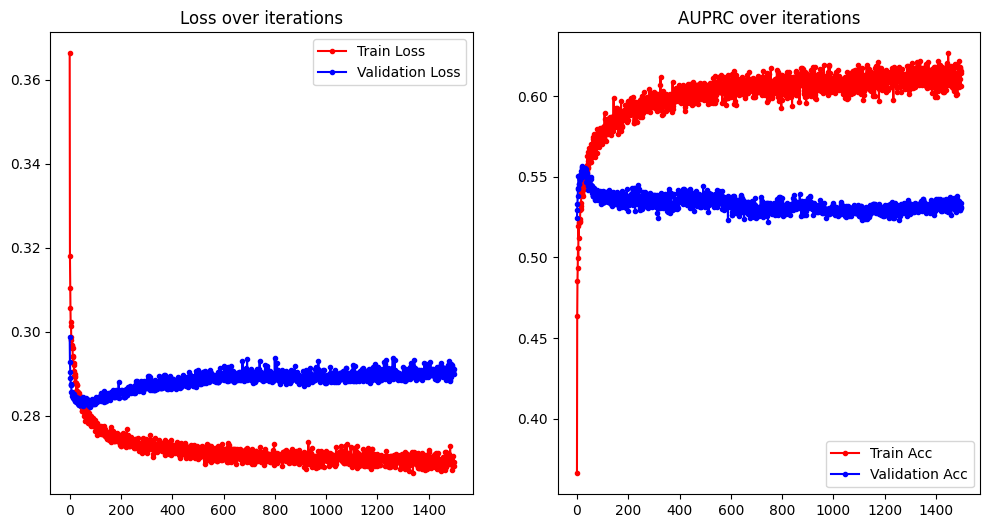

In [ ]:
n = len(history.history["loss"])

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 2, 1)
ax.plot(range(n), (history.history["loss"]), "r.", label="Train Loss", ls="-")
ax.plot(range(n), (history.history["val_loss"]),
        "b.", label="Validation Loss", ls="-")
ax.legend()
ax.set_title("Loss over iterations")

ax = fig.add_subplot(1, 2, 2)
ax.plot(range(n), (history.history["auprc_metric"]), "r.", label="Train Acc", ls="-")
ax.plot(range(n), (history.history["val_auprc_metric"]),
        "b.", label="Validation Acc", ls="-")
ax.legend(loc="lower right")
ax.set_title("AUPRC over iterations")
plt.show()

The model does not perform well on training and validation data which suggests there is some underfitting. So we can increase the model complexity. A few epochs of about 100 gives the best performance

### **2.Build Deep Learning Model+ Imbalanced Data Solution - Oversampling (CTGAN, SMOTE, ADASYN) and Undersampling**

DL with oversampling using CTGAN, gives the best performace with auprc $94\%$ which is worse than the $97\%$ from the gradient boosting model.

In [15]:
# Set multiprocessing start method to 'forkserver'
# multiprocessing.set_start_method('forkserver', force=True)

# # Enable mixed precision training
# mixed_precision.set_global_policy('mixed_float16')

# Function to train and evaluate the model
def train_evaluate_model(X_train, y_train, X_val, y_val, model_name, fold_num, epochs=100, batch_size=64):
    class_0, class_1 = np.bincount(y_train)
    total = class_0 + class_1
    print(f'Training {model_name} on Fold {fold_num} (Training size: {len(X_train)}, Validation size: {len(X_val)})')
    print(f'Class 0: {class_0} ({class_0 / total:.2%}), Class 1: {class_1} ({class_1 / total:.2%})')
    model = create_model(X_train.shape[1])
    model.fit(X_train, y_train,
              validation_data=(X_val, y_val),
              epochs=epochs, batch_size=batch_size,
              verbose=0, callbacks=[EarlyStopping(monitor='val_loss', patience=3)])
    y_pred = model.predict(X_val).ravel()
    auprc_score = auprc_metric(y_val, y_pred).numpy()
    logloss = log_loss(y_val, y_pred)
    classification_error = 1 - accuracy_score(y_val, (y_pred > 0.5).astype(int))
    print(f'{model_name} AUPRC Score on Fold {fold_num}: {auprc_score}')
    print(f'{model_name} Logloss on Fold {fold_num}: {logloss}')
    print(f'{model_name} Classification Error on Fold {fold_num}: {classification_error}')
    return auprc_score, logloss, classification_error



# Function to apply undersampling
def apply_undersampling(X_train, y_train):
    count_class_0, count_class_1 = np.bincount(y_train)
    class_0_indices = np.where(y_train == 0)[0]
    class_1_indices = np.where(y_train == 1)[0]
    class_0_indices_undersample = np.random.choice(class_0_indices, size=count_class_1, replace=False)
    undersample_indices = np.concatenate([class_0_indices_undersample, class_1_indices])
    X_train_undersample = X_train[undersample_indices]
    y_train_undersample = y_train[undersample_indices]
    return X_train_undersample, y_train_undersample

# Function to visualize the results
def visualize_results(results, title):
    metrics = ['AUPRC', 'Logloss', 'Classification Error']
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(title)
    for i, metric in enumerate(metrics):
        for key, value in results.items():
            axs[i].plot(range(1, len(value[metric])+1), value[metric], label=key)
        axs[i].set_title(metric)
        axs[i].set_xlabel('Fold')
        axs[i].set_ylabel(metric)
        axs[i].legend()
    plt.show()


In [ ]:

## Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)


# Dictionaries to store results
results = {
    'Base Deep Learning Model': {'AUPRC': [], 'Logloss': [], 'Classification Error': []},
    'ADASYN Oversampling': {'AUPRC': [], 'Logloss': [], 'Classification Error': []},
    'SMOTE Oversampling': {'AUPRC': [], 'Logloss': [], 'Classification Error': []},
    'CTGAN Oversampling': {'AUPRC': [], 'Logloss': [], 'Classification Error': []},
    'Undersampling': {'AUPRC': [], 'Logloss': [], 'Classification Error': []}
}

print(50*'-')
print('\nADASYN Oversampling\n')
X_train_ADASYN, y_train_ADASYN = apply_adasyn(Train_X_transformed, Train_y_transformed)
print(50*'-')
class_0, class_1 = np.bincount(y_train_ADASYN)
total = class_0 + class_1
print(f'Class 0: {class_0} ({class_0 / total:.2%}), Class 1: {class_1} ({class_1 / total:.2%})')
print(50*'-')

for fold_num, (train_index, val_index) in enumerate(skf.split(X_train_ADASYN, y_train_ADASYN), 1):
    X_train, X_val = X_train_ADASYN[train_index], X_train_ADASYN[val_index]
    y_train, y_val = y_train_ADASYN[train_index], y_train_ADASYN[val_index]
    # ADASYN oversampling
    auprc, logloss, error = train_evaluate_model(X_train, y_train, X_val, y_val, 'ADASYN Oversampling', fold_num)
    results['ADASYN Oversampling']['AUPRC'].append(auprc)
    results['ADASYN Oversampling']['Logloss'].append(logloss)
    results['ADASYN Oversampling']['Classification Error'].append(error)




print(50*'-')
print('\nSMOTE Oversampling\n')
X_train_SMOTE, y_train_SMOTE = apply_smote(Train_X_transformed, Train_y_transformed)
print(50*'-')
class_0, class_1 = np.bincount(y_train_SMOTE)
total = class_0 + class_1
print(f'Class 0: {class_0} ({class_0 / total:.2%}), Class 1: {class_1} ({class_1 / total:.2%})')
print(50*'-')

for fold_num, (train_index, val_index) in enumerate(skf.split(X_train_SMOTE, y_train_SMOTE), 1):
    X_train, X_val = X_train_SMOTE[train_index], X_train_SMOTE[val_index]
    y_train, y_val = y_train_SMOTE[train_index], y_train_SMOTE[val_index]
    # SMOTE oversampling
    auprc, logloss, error = train_evaluate_model(X_train, y_train, X_val, y_val, 'SMOTE Oversampling', fold_num)
    results['SMOTE Oversampling']['AUPRC'].append(auprc)
    results['SMOTE Oversampling']['Logloss'].append(logloss)
    results['SMOTE Oversampling']['Classification Error'].append(error)



print(50*'-')
print('\nCTGAN Oversampling\n')
X_train_ctgan, y_train_ctgan = apply_ctgan(Train_X_transformed, Train_y_transformed)
print(50*'-')
class_0, class_1 = np.bincount(y_train_ctgan)
total = class_0 + class_1
print(f'Class 0: {class_0} ({class_0 / total:.2%}), Class 1: {class_1} ({class_1 / total:.2%})')
print(50*'-')

for fold_num, (train_index, val_index) in enumerate(skf.split(X_train_ctgan, y_train_ctgan), 1):
    X_train, X_val = X_train_ctgan[train_index], X_train_ctgan[val_index]
    y_train, y_val = y_train_ctgan[train_index], y_train_ctgan[val_index]
    # CTGAN oversampling
    auprc, logloss, error = train_evaluate_model(X_train, y_train, X_val, y_val, 'CTGAN Oversampling', fold_num)
    results['CTGAN Oversampling']['AUPRC'].append(auprc)
    results['CTGAN Oversampling']['Logloss'].append(logloss)
    results['CTGAN Oversampling']['Classification Error'].append(error)

print(50*'-')
print('\nUndersampling\n')
X_train_undersample, y_train_undersample = apply_undersampling(Train_X_transformed, Train_y_transformed)
print(50*'-')
class_0, class_1 = np.bincount(y_train_undersample)
total = class_0 + class_1
print(f'Class 0: {class_0} ({class_0 / total:.2%}), Class 1: {class_1} ({class_1 / total:.2%})')

# Efficiently process each fold
for fold_num, (train_index, val_index) in enumerate(skf.split(X_train_undersample, y_train_undersample), 1):
    X_train, X_val = X_train_undersample[train_index], X_train_undersample[val_index]
    y_train, y_val = y_train_undersample[train_index], y_train_undersample[val_index]
    # Undersampling
    auprc, logloss, error = train_evaluate_model(X_train, y_train, X_val, y_val, 'Undersampling', fold_num)
    results['Undersampling']['AUPRC'].append(auprc)
    results['Undersampling']['Logloss'].append(logloss)
    results['Undersampling']['Classification Error'].append(error)

print(50*'-')
print('\nBase Deep Learning Model\n')
print(50*'-')
class_0, class_1 = np.bincount(Train_y_transformed)
total = class_0 + class_1
print(f'Class 0: {class_0} ({class_0 / total:.2%}), Class 1: {class_1} ({class_1 / total:.2%})')

# Efficiently process each fold
for fold_num, (train_index, val_index) in enumerate(skf.split(Train_X_transformed, Train_y_transformed), 1):
    X_train, X_val = Train_X_transformed[train_index], Train_X_transformed[val_index]
    y_train, y_val = Train_y_transformed[train_index], Train_y_transformed[val_index]

    # Base model without resampling
    auprc, logloss, error = train_evaluate_model(X_train, y_train, X_val, y_val, 'Base Model', fold_num)
    results['Base Deep Learning Model']['AUPRC'].append(auprc)
    results['Base Deep Learning Model']['Logloss'].append(logloss)
    results['Base Deep Learning Model']['Classification Error'].append(error)

--------------------------------------------------

ADASYN Oversampling

--------------------------------------------------
Class 0: 21115 (49.66%), Class 1: 21408 (50.34%)
--------------------------------------------------
Training ADASYN Oversampling on Fold 1 (Training size: 28348, Validation size: 14175)
Class 0: 14076 (49.65%), Class 1: 14272 (50.35%)
443/443 [==============================] - 1s 2ms/step
ADASYN Oversampling AUPRC Score on Fold 1: 0.8462225198745728
ADASYN Oversampling Logloss on Fold 1: 0.9401002638624302
ADASYN Oversampling Classification Error on Fold 1: 0.19887125220458557
Training ADASYN Oversampling on Fold 2 (Training size: 28349, Validation size: 14174)
Class 0: 14077 (49.66%), Class 1: 14272 (50.34%)
443/443 [==============================] - 1s 3ms/step
ADASYN Oversampling AUPRC Score on Fold 2: 0.8397827744483948
ADASYN Oversampling Logloss on Fold 2: 0.9555575719096318
ADASYN Oversampling Classification Error on Fold 2: 0.19775645548186815
Training ADA

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


--------------------------------------------------
Class 0: 21115 (57.19%), Class 1: 15809 (42.81%)
--------------------------------------------------
Training CTGAN Oversampling on Fold 1 (Training size: 24616, Validation size: 12308)
Class 0: 14076 (57.18%), Class 1: 10540 (42.82%)
385/385 [==============================] - 1s 2ms/step
CTGAN Oversampling AUPRC Score on Fold 1: 0.9389550685882568
CTGAN Oversampling Logloss on Fold 1: 0.8015408752881205
CTGAN Oversampling Classification Error on Fold 1: 0.14161520961975949
Training CTGAN Oversampling on Fold 2 (Training size: 24616, Validation size: 12308)
Class 0: 14077 (57.19%), Class 1: 10539 (42.81%)
385/385 [==============================] - 1s 2ms/step
CTGAN Oversampling AUPRC Score on Fold 2: 0.9356598258018494
CTGAN Oversampling Logloss on Fold 2: 0.814813403715095
CTGAN Oversampling Classification Error on Fold 2: 0.14730256743581416
Training CTGAN Oversampling on Fold 3 (Training size: 24616, Validation size: 12308)
Class 0: 

In [ ]:
# Print final results
print(f'\nFinal Results:')
print(30*'-')
for model_name, metrics in results.items():
    print(f'\n{model_name}:\n')
    print(50*'-')
    for metric_name, scores in metrics.items():
        print(f'  {metric_name}: {scores}')
        print(f'  Mean {metric_name}: {np.mean(scores)}')
        print(50*'.')



Final Results:
------------------------------

Base Deep Learning Model:

--------------------------------------------------
  AUPRC: [0.5165816, 0.51692396, 0.51731414]
  Mean AUPRC: 0.5169398784637451
..................................................
  Logloss: [0.7827891083653018, 0.8198144371158871, 0.7788886870214917]
  Mean Logloss: 0.7938307441675603
..................................................
  Classification Error: [0.13965057024993932, 0.1391652511526329, 0.13384298022084695]
  Mean Classification Error: 0.13755293387447307
..................................................

ADASYN Oversampling:

--------------------------------------------------
  AUPRC: [0.8462225, 0.8397828, 0.8334211]
  Mean AUPRC: 0.8398087620735168
..................................................
  Logloss: [0.9401002638624302, 0.9555575719096318, 0.9748284826004758]
  Mean Logloss: 0.9568287727908459
..................................................
  Classification Error: [0.19887125220458

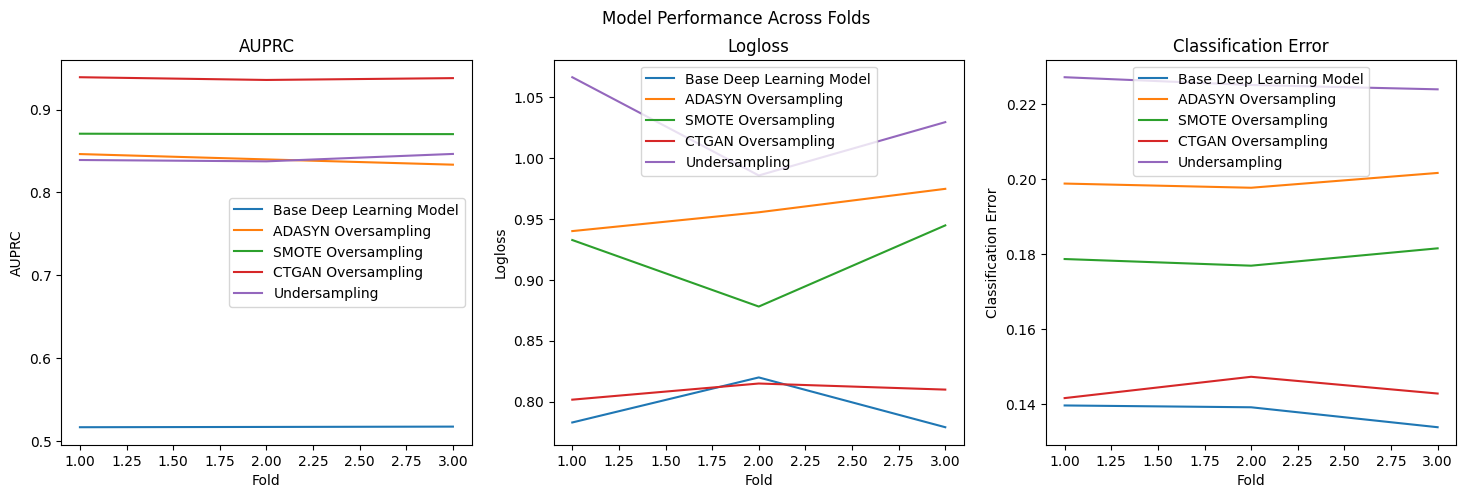

In [ ]:
# Visualize the results
visualize_results(results, 'Model Performance Across Folds')

### **Hyperparameter Tunning with Hyperopt for DNN**

The best hyperparameters are:

{'batch_size': 127.0, 'dropout_layer1': 0.309590397156984, 'dropout_layer2': 0.26189561691542773, 'learning_rate': 0.03808296255585596, 'units_layer1': 103.0, 'units_layer2': 78.0}

The model performance after the optimising did not improve the performance


In [ ]:
from hyperopt.pyll.base import scope

# Function to create the model
def create_model_(input_dim, params):
    tf.random.set_seed(1234)  # applied to achieve consistent results

    model = Sequential([
        tf.keras.Input(shape=(input_dim,)),
        Dense(params['units_layer1'], activation='relu', kernel_initializer="he_uniform"),
        Dropout(params['dropout_layer1']),  # Reduced dropout for faster convergence
        Dense(params['units_layer2'], activation='relu', kernel_initializer="he_uniform"),
        Dropout(params['dropout_layer2']),
        Dense(1, activation="linear")  # Ensure output is float32 for compatibility
    ])
    # softmax is not numerically stable hence the choice of linear activation and from_logits sets to True
    loss_function_used = BinaryCrossentropy(from_logits=True)
    # opt = Adam(learning_rate=0.001)
    opt = RMSprop(learning_rate=params['learning_rate'])
    model.compile(optimizer=opt,
                  loss=loss_function_used,
                  metrics=[auprc_metric])
    return model

# retrain the DL
X_train_ctgan, y_train_ctgan = apply_ctgan(Train_X_transformed, Train_y_transformed)
X_test_ctgan, y_test_ctgan = apply_ctgan(Test_X_transformed, Test_y_transformed)


def objective(params):
    model = create_model(Train_X_transformed.shape[1], params)
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    history = model.fit(X_train_ctgan, y_train_ctgan,
                        validation_data=(X_test_ctgan, y_test_ctgan),
                        epochs=10,
                        batch_size=params['batch_size'],
                        callbacks=[early_stopping],
                        verbose=0)

    y_val_pred = model.predict(X_test_ctgan)
    y_val_true = y_test_ctgan
    y_val_pred_proba = y_val_pred

    auprc = average_precision_score(y_val_true, y_val_pred_proba, average='macro')
    return {'loss': -auprc, 'status': STATUS_OK}


# Define the search space
space = {
    'units_layer1': scope.int(hp.quniform('units_layer1', 32, 256, 1)),
    'dropout_layer1': hp.uniform('dropout_layer1', 0.2, 0.5),
    'units_layer2': scope.int(hp.quniform('units_layer2', 32, 256, 1)),
    'dropout_layer2': hp.uniform('dropout_layer2', 0.2, 0.5),
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-5), np.log(1e-1)),
    'batch_size': scope.int(hp.quniform('batch_size', 32, 256, 1))
}

# Run the optimization
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=5,
            trials=trials)

print('Best hyperparameters:')
print(best)

# Extract the best parameters and train the final model
best_params = {
    'units_layer1': int(best['units_layer1']),
    'dropout_layer1': best['dropout_layer1'],
    'units_layer2': int(best['units_layer2']),
    'dropout_layer2': best['dropout_layer2'],
    'learning_rate': best['learning_rate'],
    'batch_size': int(best['batch_size'])
}

final_model = create_model(Train_X_transformed.shape[1], best_params)
final_model.fit(X_train_ctgan, y_train_ctgan, validation_data=(X_test_ctgan, y_test_ctgan), epochs=20, batch_size=best_params['batch_size'])

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


290/290 [==============================] - 3s 10ms/step

290/290 [==============================] - 2s 7ms/step

290/290 [==============================] - 5s 18ms/step

290/290 [==============================] - 2s 6ms/step

290/290 [==============================] - 2s 6ms/step

100%|██████████| 5/5 [18:19<00:00, 219.97s/trial, best loss: -0.9094708923304041]
Best hyperparameters:
{'batch_size': 127.0, 'dropout_layer1': 0.309590397156984, 'dropout_layer2': 0.26189561691542773, 'learning_rate': 0.03808296255585596, 'units_layer1': 103.0, 'units_layer2': 78.0}
Epoch 1/20
291/291 [==============================] - 22s 69ms/step - loss: 0.4613 - auprc_metric: 0.8773 - val_loss: 0.4097 - val_auprc_metric: 0.6423
Epoch 2/20
291/291 [==============================] - 14s 48ms/step - loss: 0.3538 - auprc_metric: 0.9141 - val_loss: 0.3762 - val_auprc_metric: 0.6448
Epoch 3/20
291/291 [==============================] - 17s 59ms/step - loss: 0.3433 - auprc_metric: 0.9193 - val_loss: 0.3951 - va

In [ ]:
# Function to create the model
def create_model_(input_dim, params):
    tf.random.set_seed(1234)  # applied to achieve consistent results

    model = Sequential([
        tf.keras.Input(shape=(input_dim,)),
        Dense(params['units_layer1'], activation='relu', kernel_initializer="he_uniform"),
        Dropout(params['dropout_layer1']),  # Reduced dropout for faster convergence
        Dense(params['units_layer2'], activation='relu', kernel_initializer="he_uniform"),
        Dropout(params['dropout_layer2']),
        Dense(1, activation="linear")  # Ensure output is float32 for compatibility
    ])
    # softmax is not numerically stable hence the choice of linear activation and from_logits sets to True
    loss_function_used = BinaryCrossentropy(from_logits=True)
    # opt = Adam(learning_rate=0.001)
    opt = RMSprop(learning_rate=params['learning_rate'])
    model.compile(optimizer=opt,
                  loss=loss_function_used,
                  metrics=[auprc_metric])
    return model

# Function to train and evaluate the model
def train_evaluate_model_(X_train, y_train, X_val, y_val, model_name, fold_num, epochs=100, batch_size=best_params['batch_size']):
    class_0, class_1 = np.bincount(y_train)
    total = class_0 + class_1
    print(f'Training {model_name} on Fold {fold_num} (Training size: {len(X_train)}, Validation size: {len(X_val)})')
    print(f'Class 0: {class_0} ({class_0 / total:.2%}), Class 1: {class_1} ({class_1 / total:.2%})')
    model = create_model_(X_train.shape[1], best_params)
    model.fit(X_train, y_train,
              validation_data=(X_val, y_val),
              epochs=epochs, batch_size=batch_size,
              verbose=0, callbacks=[EarlyStopping(monitor='val_loss', patience=3)])
    y_pred = model.predict(X_val).ravel()
    auprc_score = auprc_metric(y_val, y_pred).numpy()
    logloss = log_loss(y_val, y_pred)
    classification_error = 1 - accuracy_score(y_val, (y_pred > 0.5).astype(int))
    print(f'{model_name} AUPRC Score on Fold {fold_num}: {auprc_score}')
    print(f'{model_name} Logloss on Fold {fold_num}: {logloss}')
    print(f'{model_name} Classification Error on Fold {fold_num}: {classification_error}')
    return auprc_score, logloss, classification_error


skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Dictionaries to store results
results = {'CTGAN Oversampling': {'AUPRC': [], 'Logloss': [], 'Classification Error': []}}

for fold_num, (train_index, val_index) in enumerate(skf.split(X_train_ctgan, y_train_ctgan), 1):
    X_train, X_val = X_train_ctgan[train_index], X_train_ctgan[val_index]
    y_train, y_val = y_train_ctgan[train_index], y_train_ctgan[val_index]
    # CTGAN oversampling
    auprc, logloss, error = train_evaluate_model_(X_train, y_train, X_val, y_val, 'CTGAN Oversampling', fold_num)
    results['CTGAN Oversampling']['AUPRC'].append(auprc)
    results['CTGAN Oversampling']['Logloss'].append(logloss)
    results['CTGAN Oversampling']['Classification Error'].append(error)

Training CTGAN Oversampling on Fold 1 (Training size: 24626, Validation size: 12313)
Class 0: 14076 (57.16%), Class 1: 10550 (42.84%)
385/385 [==============================] - 2s 4ms/step
CTGAN Oversampling AUPRC Score on Fold 1: 0.9303909540176392
CTGAN Oversampling Logloss on Fold 1: 1.0905135021014707
CTGAN Oversampling Classification Error on Fold 1: 0.16405425160399578
Training CTGAN Oversampling on Fold 2 (Training size: 24626, Validation size: 12313)
Class 0: 14077 (57.16%), Class 1: 10549 (42.84%)
385/385 [==============================] - 4s 10ms/step
CTGAN Oversampling AUPRC Score on Fold 2: 0.9347313642501831
CTGAN Oversampling Logloss on Fold 2: 1.0521314519346814
CTGAN Oversampling Classification Error on Fold 2: 0.15918135304150083
Training CTGAN Oversampling on Fold 3 (Training size: 24626, Validation size: 12313)
Class 0: 14077 (57.16%), Class 1: 10549 (42.84%)
385/385 [==============================] - 4s 9ms/step
CTGAN Oversampling AUPRC Score on Fold 3: 0.9304594397

In [ ]:
# Print final results
print(f'\nFinal Results:')
print(30*'-')
for model_name, metrics in results.items():
    print(f'\n{model_name}:\n')
    print(50*'-')
    for metric_name, scores in metrics.items():
        print(f'  {metric_name}: {scores}')
        print(f'  Mean {metric_name}: {np.mean(scores)}')
        print(50*'.')


Final Results:
------------------------------

CTGAN Oversampling:

--------------------------------------------------
  AUPRC: [0.93039095, 0.93473136, 0.93045944]
  Mean AUPRC: 0.931860625743866
..................................................
  Logloss: [1.0905135021014707, 1.0521314519346814, 1.0749646570676892]
  Mean Logloss: 1.0725365370346138
..................................................
  Classification Error: [0.16405425160399578, 0.15918135304150083, 0.16072443758629096]
  Mean Classification Error: 0.1613200140772625
..................................................


In [ ]:
# n = len(history.history["loss"])

# fig = plt.figure(figsize=(12, 6))
# ax = fig.add_subplot(1, 2, 1)
# ax.plot(range(n), (history.history["loss"]), "r.", label="Train Loss", ls="-")
# ax.plot(range(n), (history.history["val_loss"]),
#         "b.", label="Validation Loss", ls="-")
# ax.legend()
# ax.set_title("Loss over iterations")

# ax = fig.add_subplot(1, 2, 2)
# ax.plot(range(n), (history.history["auprc_metric"]), "r.", label="Train Acc", ls="-")
# ax.plot(range(n), (history.history["val_auprc_metric"]),
#         "b.", label="Validation Acc", ls="-")
# ax.legend(loc="lower right")
# ax.set_title("AUPRC over iterations with CTGAN")
# plt.show()

# **Modelling Part III**

## **Finding Best Model (Model Selection): 45 Supervised Model + Imbalanced Data Solutions**

There are some models that will perform better on a balanced dataset than others. Here, equal treatment is given to all models by applying the imbalance solution. Gradient boosting with CTGAN is still the best out-of-the-box performing model with auprc score of $96.9\%$

In [ ]:
# Setting up models
models = {
    'Naive Bayes': GaussianNB(),
    'Logistic Regression': LogisticRegression(class_weight='balanced', solver='saga', max_iter=200, random_state=42),
    'Decision Tree': DecisionTreeClassifier(class_weight='balanced', random_state=42),
    'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(scale_pos_weight=sum(Train_y_transformed == 0) / sum(Train_y_transformed == 1),random_state=42),  # XGBoost handles imbalance by scale_pos_weight
    'Extra Trees': ExtraTreesClassifier(class_weight='balanced', random_state=42),
    'AdaBoost': AdaBoostClassifier(estimator=DecisionTreeClassifier(class_weight='balanced',random_state=42)),
    'BaggingClassifier': BaggingClassifier(estimator=ExtraTreeClassifier(random_state=42), n_estimators=100)
}


results = {}
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

# 1. SMOTE
# smote = SMOTE(random_state=42)
Train_X_smote, Train_y_smote = apply_smote(Train_X_transformed, Train_y_transformed)

# 2. ADASYN
# adasyn = ADASYN(random_state=42)
Train_X_adasyn, Train_y_adasyn = apply_adasyn(Train_X_transformed, Train_y_transformed)

# 3. Random Undersampling
# undersampler = RandomUnderSampler(random_state=42)
Train_X_undersample, Train_y_undersample = apply_undersampling(Train_X_transformed, Train_y_transformed)

# 4. CTGAN
X_train_ctgan, y_train_ctgan = apply_ctgan(Train_X_transformed, Train_y_transformed)


#results = []

for name, model in models.items():

        cv_scores_ctgan = evaluate_model(model, X_train_ctgan, y_train_ctgan)
        results[f'{name} CTGAN'] = []
        results[f'{name} CTGAN'].append(cv_scores_ctgan.mean())
        #print(f'{name} + ctgan AUPRC Scores: {cv_scores_ctgan}')
        print(f'Mean AUPRC Score {name} + CTGAN: {cv_scores_ctgan.mean()}')

        cv_scores_smote = evaluate_model(model, Train_X_smote, Train_y_smote)
        results[f'{name} SMOTE'] = []
        results[f'{name} SMOTE'].append(cv_scores_smote.mean())
        #print(f'{name} + SMOTE AUPRC Scores: {cv_scores_smote}')
        print(f'Mean AUPRC Score {name} + SMOTE: {cv_scores_smote.mean()}')

        cv_scores_adasyn = evaluate_model(model, Train_X_adasyn, Train_y_adasyn)
        results[f'{name} ADASYN'] = []
        results[f'{name} ADASYN'].append(cv_scores_adasyn.mean())
        #print(f'{name} ADASYN AUPRC Scores: {cv_scores_adasyn}')
        print(f'Mean AUPRC Score {name} + ADASYN: {cv_scores_adasyn.mean()}')

        cv_scores_undersample = evaluate_model(model, Train_X_undersample, Train_y_undersample)
        results[f'{name} UNDERSAMPLE'] = []
        results[f'{name} UNDERSAMPLE'].append(cv_scores_undersample.mean())
        #print(f'{name} UNDERSAMPLE AUPRC Scores: {cv_scores_undersample}')
        print(f'Mean AUPRC Score {name} + UNDERSAMPLE: {cv_scores_undersample.mean()}')

        cv_scores = evaluate_model(model, Train_X_transformed, Train_y_transformed)
        results[f'{name} ORIGINAL'] = []
        results[f'{name} ORIGINAL'].append(cv_scores.mean())
        #print(f'{name} ORIGINAL AUPRC Scores: {cv_scores}')
        print(f'Mean AUPRC Score ORIGINAL {name}: {cv_scores.mean()}')

# Find and print the best model based on AUPRC
best_model = max(results, key=lambda x: x[1])
print(f"Best model based on AUPRC: {best_model} with an AUPRC of {results[best_model][0]:.4f}")

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Mean AUPRC Score Naive Bayes + CTGAN: 0.6766093135351793
Mean AUPRC Score Naive Bayes + SMOTE: 0.769266430701435
Mean AUPRC Score Naive Bayes + ADASYN: 0.7382206487683872
Mean AUPRC Score Naive Bayes + UNDERSAMPLE: 0.7613336163532773
Mean AUPRC Score ORIGINAL Naive Bayes: 0.36924710592051807
Mean AUPRC Score Logistic Regression + CTGAN: 0.8079362717679164
Mean AUPRC Score Logistic Regression + SMOTE: 0.8397659156150171
Mean AUPRC Score Logistic Regression + ADASYN: 0.8044865738801366
Mean AUPRC Score Logistic Regression + UNDERSAMPLE: 0.8419987824813129
Mean AUPRC Score ORIGINAL Logistic Regression: 0.4872768761053688
Mean AUPRC Score Decision Tree + CTGAN: 0.8860120694864002
Mean AUPRC Score Decision Tree + SMOTE: 0.8743238452869475
Mean AUPRC Score Decision Tree + ADASYN: 0.8653903434729334
Mean AUPRC Score Decision Tree + UNDERSAMPLE: 0.7884903747163778
Mean AUPRC Score ORIGINAL Decision Tree: 0.41533690628365544
Mean AUPRC Score Random Forest + CTGAN: 0.9636056724773665
Mean AUPRC 

In [ ]:
pd.DataFrame(results).rename(index = {0 : 'Mean AUCPR'}).T.sort_values(by = 'Mean AUCPR', ascending = False)

,Mean AUCPR
Gradient Boosting CTGAN,0.969695
XGBoost CTGAN,0.967374
Random Forest CTGAN,0.963606
BaggingClassifier CTGAN,0.961354
XGBoost SMOTE,0.960790
XGBoost ADASYN,0.957937
Extra Trees CTGAN,0.952584
AdaBoost CTGAN,0.945714
Random Forest SMOTE,0.938254
Gradient Boosting SMOTE,0.934044


# **Principal Component Analysis (PCA)**

Here we apply PCA to reduce the feature dimensions and explore its effect on the performace of the various model

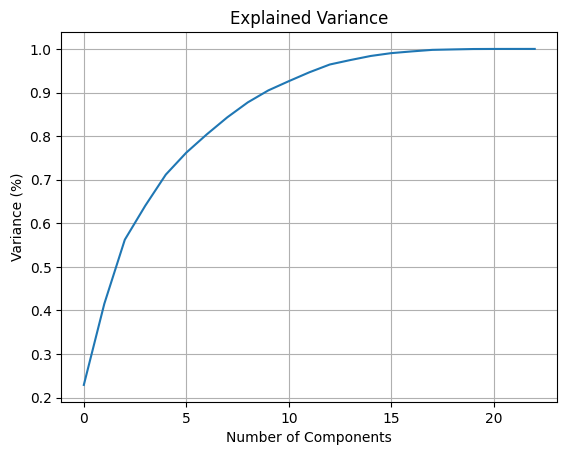

In [24]:
# Perform PCA
pca = PCA().fit(Train_X_transformed)

# Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') # for each component
plt.title('Explained Variance')
plt.grid(True)
plt.show()


In [25]:
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
optimal_num_components = np.argmax(cumulative_variance >= 0.95) + 1  # Adjust the threshold as necessary
print(f"Optimal number of components by 95% variance: {optimal_num_components}")

Optimal number of components by 95% variance: 13


#### **Composition of PCA**

In [ ]:
# Refit PCA with the optimal number of components
pca_optimal = PCA(n_components=optimal_num_components)
Train_X_pca = pca_optimal.fit_transform(Train_X_transformed)
feature_names = feature_transformer.get_feature_names_out()

# Components
components = pca_optimal.components_

# Creating a DataFrame with loadings
components_df = pd.DataFrame(components.T, columns=[f'PC{i+1}' for i in range(components.shape[0])], index=feature_names)
components_df


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13
num__log_campaign,-0.633075,0.264295,0.696343,0.005100,-0.076740,0.148656,0.012754,-0.002181,0.122385,0.027440,0.007146,0.015543,0.002915
num__log_duration,0.426220,-0.648942,0.629001,0.001095,-0.008996,0.014116,-0.013418,0.009555,0.004151,0.018910,-0.017483,-0.014547,0.009000
num__log_previous,0.569170,0.680349,0.322139,0.021290,0.102237,-0.160156,0.025616,0.011515,-0.074908,-0.004389,-0.010133,-0.012784,0.034845
cat__education_secondary,0.020143,0.005014,-0.012864,0.550955,-0.442197,-0.173882,0.086960,0.044606,0.068185,-0.029899,-0.092838,-0.090985,-0.080583
cat__education_tertiary,-0.012672,-0.000750,0.008927,-0.574686,0.342823,0.103160,0.008925,-0.013568,-0.035648,0.066511,-0.061392,-0.047559,-0.052252
cat__loan_yes,-0.016196,-0.006480,-0.008406,0.066686,-0.000981,-0.087029,-0.018911,-0.018291,-0.131360,0.680016,-0.329256,0.630592,0.006685
cat__quarter_2nd quarter,0.122604,0.065937,-0.016594,0.008656,-0.250414,0.626884,-0.071123,-0.201923,-0.278440,-0.078025,-0.010428,0.108173,-0.320570
cat__quarter_3rd quarter,-0.206471,-0.084583,0.084381,0.018869,0.192415,-0.589767,0.120728,-0.043377,-0.468636,-0.172392,-0.015609,0.001262,-0.081479
cat__quarter_4th quarter,0.049444,0.006090,-0.045305,-0.022580,0.043568,-0.041611,-0.119263,0.288094,0.598524,0.239567,-0.022015,-0.134939,0.186949
cat__age_group_30-45,0.008227,0.029779,0.008430,-0.425775,-0.528682,-0.264685,-0.235344,-0.061730,0.002359,0.062106,-0.134611,-0.164178,-0.030710


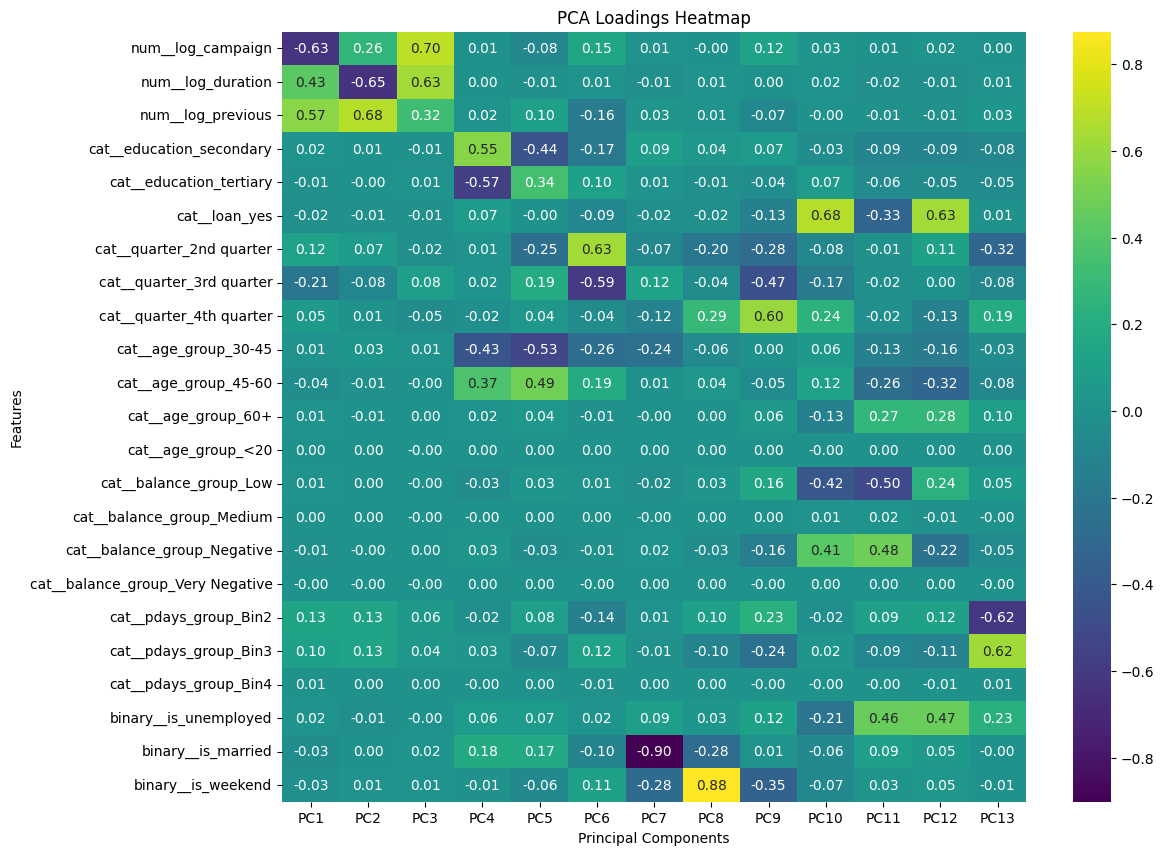

In [ ]:
plt.figure(figsize=(12, 10))
sns.heatmap(components_df, cmap='viridis', annot=True, fmt=".2f")
plt.title('PCA Loadings Heatmap')
plt.xlabel('Principal Components')
plt.ylabel('Features')
plt.show()

## **Finding Best Model (Model Selection): 45 Supervised Model + Imbalanced Data Solutions + PCA**

XGBoost with pca dimension of 13 and CTGAN oversampling gives the same performances of $95.7\%$ as our previous best model $97\%$: gradient boosting with CTGAN with 23 dimension. Going forward, it will better to choose XGBoost with CTGAN and PCA as the best model. Since a lower dimension model gives a better stability at the expense of $1\%$ loss in performance


In [ ]:
pca_optimal = PCA(n_components=optimal_num_components)
Train_X_pca = pca_optimal.fit_transform(Train_X_transformed)


# Setting up models
models = {
    'Naive Bayes': GaussianNB(),
    'Logistic Regression': LogisticRegression(class_weight='balanced', solver='saga', max_iter=200, random_state=42),
    'Decision Tree': DecisionTreeClassifier(class_weight='balanced', random_state=42),
    'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(scale_pos_weight=sum(Train_y_transformed == 0) / sum(Train_y_transformed == 1),random_state=42),  # XGBoost handles imbalance by scale_pos_weight
    'Extra Trees': ExtraTreesClassifier(class_weight='balanced', random_state=42),
    'AdaBoost': AdaBoostClassifier(estimator=DecisionTreeClassifier(class_weight='balanced',random_state=42)),
    'BaggingClassifier': BaggingClassifier(estimator=ExtraTreeClassifier(random_state=42), n_estimators=100)
}


results = {}
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

# 1. SMOTE
# smote = SMOTE(random_state=42)
Train_X_smote, Train_y_smote = apply_smote(Train_X_pca, Train_y_transformed)

# 2. ADASYN
# adasyn = ADASYN(random_state=42)
Train_X_adasyn, Train_y_adasyn = apply_adasyn(Train_X_pca, Train_y_transformed)

# 3. Random Undersampling
# undersampler = RandomUnderSampler(random_state=42)
Train_X_undersample, Train_y_undersample = apply_undersampling(Train_X_pca, Train_y_transformed)

# 4. CTGAN
X_train_ctgan, y_train_ctgan = apply_ctgan(Train_X_pca, Train_y_transformed)


#results = []

for name, model in models.items():

        cv_scores_ctgan = evaluate_model(model, X_train_ctgan, y_train_ctgan)
        results[f'{name} CTGAN'] = []
        results[f'{name} CTGAN'].append(cv_scores_ctgan.mean())
        #print(f'{name} + ctgan AUPRC Scores: {cv_scores_ctgan}')
        print(f'Mean AUPRC Score {name} + CTGAN: {cv_scores_ctgan.mean()}')

        cv_scores_smote = evaluate_model(model, Train_X_smote, Train_y_smote)
        results[f'{name} SMOTE'] = []
        results[f'{name} SMOTE'].append(cv_scores_smote.mean())
        #print(f'{name} + SMOTE AUPRC Scores: {cv_scores_smote}')
        print(f'Mean AUPRC Score {name} + SMOTE: {cv_scores_smote.mean()}')

        cv_scores_adasyn = evaluate_model(model, Train_X_adasyn, Train_y_adasyn)
        results[f'{name} ADASYN'] = []
        results[f'{name} ADASYN'].append(cv_scores_adasyn.mean())
        #print(f'{name} ADASYN AUPRC Scores: {cv_scores_adasyn}')
        print(f'Mean AUPRC Score {name} + ADASYN: {cv_scores_adasyn.mean()}')

        cv_scores_undersample = evaluate_model(model, Train_X_undersample, Train_y_undersample)
        results[f'{name} UNDERSAMPLE'] = []
        results[f'{name} UNDERSAMPLE'].append(cv_scores_undersample.mean())
        #print(f'{name} UNDERSAMPLE AUPRC Scores: {cv_scores_undersample}')
        print(f'Mean AUPRC Score {name} + UNDERSAMPLE: {cv_scores_undersample.mean()}')

        cv_scores = evaluate_model(model, Train_X_pca, Train_y_transformed)
        results[f'{name} ORIGINAL'] = []
        results[f'{name} ORIGINAL'].append(cv_scores.mean())
        #print(f'{name} ORIGINAL AUPRC Scores: {cv_scores}')
        print(f'Mean AUPRC Score ORIGINAL {name}: {cv_scores.mean()}')

# Find and print the best model based on AUPRC
best_model = max(results, key=lambda x: x[1])
print(f"Best model based on AUPRC: {best_model} with an AUPRC of {results[best_model][0]:.4f}")

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Mean AUPRC Score Naive Bayes + CTGAN: 0.7098346910012099
Mean AUPRC Score Naive Bayes + SMOTE: 0.8154039820383759
Mean AUPRC Score Naive Bayes + ADASYN: 0.782352596847375
Mean AUPRC Score Naive Bayes + UNDERSAMPLE: 0.8149335113213851
Mean AUPRC Score ORIGINAL Naive Bayes: 0.44225163866526856
Mean AUPRC Score Logistic Regression + CTGAN: 0.6885025762225933
Mean AUPRC Score Logistic Regression + SMOTE: 0.834158272194867
Mean AUPRC Score Logistic Regression + ADASYN: 0.7992024135463659
Mean AUPRC Score Logistic Regression + UNDERSAMPLE: 0.8380752169148519
Mean AUPRC Score ORIGINAL Logistic Regression: 0.47865855152539
Mean AUPRC Score Decision Tree + CTGAN: 0.8504197101243921
Mean AUPRC Score Decision Tree + SMOTE: 0.8704116371992142
Mean AUPRC Score Decision Tree + ADASYN: 0.8638241645256349
Mean AUPRC Score Decision Tree + UNDERSAMPLE: 0.7769967636585847
Mean AUPRC Score ORIGINAL Decision Tree: 0.41382272268064657
Mean AUPRC Score Random Forest + CTGAN: 0.944090535051492
Mean AUPRC Scor

In [ ]:
pd.DataFrame(results).rename(index = {0 : 'Mean AUCPR'}).T.sort_values(by = 'Mean AUCPR', ascending = False)

,Mean AUCPR
XGBoost CTGAN,0.958673
Random Forest CTGAN,0.944091
BaggingClassifier CTGAN,0.939067
Gradient Boosting CTGAN,0.924955
BaggingClassifier SMOTE,0.912663
Random Forest SMOTE,0.910907
XGBoost SMOTE,0.910887
Extra Trees SMOTE,0.899262
XGBoost ADASYN,0.891186
BaggingClassifier ADASYN,0.886562


## **Outlier Removal using Clustering**

### k-means

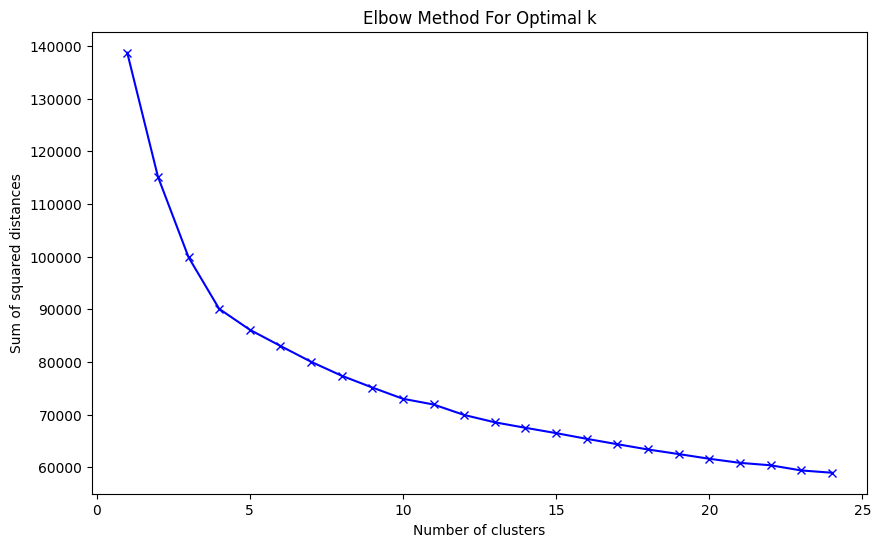

In [ ]:
# Calculate sum of squared distances
sum_of_squared_distances = []

K = range(1, 25)  # Assuming we test up to 14 clusters
for k in K:
    km = KMeans(n_clusters=k,
                random_state = 42, n_init=10)
    km = km.fit(Train_X_transformed)
    sum_of_squared_distances.append(km.inertia_)

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()


In [ ]:
# Choose k from the elbow plot visually, let's say it appears to be 3
optimal_k = 12
feature_names = feature_transformer.get_feature_names_out()

kmeans = KMeans(n_clusters=optimal_k,
                random_state = RANDOM_STATE ,
                n_init=10)
kmeans.fit(Train_X_transformed)
def format_float(value):
    return f'{value:,.5f}'

pd.options.display.float_format = format_float

# Create a DataFrame with cluster centers
cluster_centers_df = pd.DataFrame(kmeans.cluster_centers_, columns=feature_names)
cluster_centers_df.T


,0,1,2,3,4,5,6,7,8,9,10,11
num__log_campaign,-0.41662,1.16821,-0.45967,0.40581,-0.46185,-0.48433,1.09204,2.86076,-0.37816,-0.44888,-0.41717,-0.54880
num__log_duration,-0.29133,0.90619,-0.30131,-0.35660,1.53221,-0.07896,-0.92691,-1.00880,1.37552,-0.31735,-0.39818,-0.28807
num__log_previous,1.15336,-0.49020,-0.51216,2.94312,-0.51240,-0.51679,-0.47046,-0.48530,1.50145,-0.51259,-0.51361,1.23767
cat__education_secondary,0.61693,0.46531,0.00000,0.53457,0.52597,0.84890,0.48678,0.49231,0.52864,0.92873,0.46266,0.48427
cat__education_tertiary,0.22626,0.38702,0.95285,0.33496,0.31602,0.00000,0.34343,0.36813,0.34056,0.00000,0.29742,0.42720
cat__loan_yes,0.16386,0.16799,0.12034,0.14314,0.15147,0.13694,0.17286,0.20000,0.11378,0.21913,0.22141,0.12533
cat__quarter_2nd quarter,0.73250,0.09514,0.22379,0.49270,0.28623,0.99580,0.19318,0.05055,0.49768,-0.00000,0.09749,0.24000
cat__quarter_3rd quarter,0.02442,0.77502,0.39796,0.12561,0.36942,0.00000,0.66539,0.88901,0.14706,0.60709,0.56841,0.20267
cat__quarter_4th quarter,0.02279,0.05600,0.19388,0.17429,0.18198,0.00000,0.05903,0.01209,0.18653,0.19893,0.20787,0.39360
cat__age_group_30-45,0.62344,0.50000,0.80894,0.59591,0.50817,0.62959,0.53545,0.58571,0.50155,0.79840,0.00000,0.54293


In [ ]:
# Add cluster labels to your original DataFrame
Train_X_transformed_df = pd.DataFrame(Train_X_transformed, columns=feature_names)
Train_X_transformed_df['cluster'] = kmeans.labels_
# Add Train_y_transformed to the DataFrame
Train_X_transformed_df['y'] = Train_y_transformed

# Calculate the average outcome for each cluster and the number of points per cluster
cluster_summary = Train_X_transformed_df.groupby('cluster').agg({
    'y': 'mean',
    'cluster': 'count'  # Count per cluster
}).rename(columns={'y': 'Percentage of class 1', 'cluster': 'Count'})

# Retrieve cluster centers
cluster_centers_df = pd.DataFrame(kmeans.cluster_centers_, columns=feature_names)
cluster_centers_df['Percentage of class 1'] = cluster_summary['Percentage of class 1'].values
cluster_centers_df['Count'] = cluster_summary['Count'].values

cluster_centers_df.T


,0,1,2,3,4,5,6,7,8,9,10,11
num__log_campaign,-0.41662,1.16821,-0.45967,0.40581,-0.46185,-0.48433,1.09204,2.86076,-0.37816,-0.44888,-0.41717,-0.54880
num__log_duration,-0.29133,0.90619,-0.30131,-0.35660,1.53221,-0.07896,-0.92691,-1.00880,1.37552,-0.31735,-0.39818,-0.28807
num__log_previous,1.15336,-0.49020,-0.51216,2.94312,-0.51240,-0.51679,-0.47046,-0.48530,1.50145,-0.51259,-0.51361,1.23767
cat__education_secondary,0.61693,0.46531,0.00000,0.53457,0.52597,0.84890,0.48678,0.49231,0.52864,0.92873,0.46266,0.48427
cat__education_tertiary,0.22626,0.38702,0.95285,0.33496,0.31602,0.00000,0.34343,0.36813,0.34056,0.00000,0.29742,0.42720
cat__loan_yes,0.16386,0.16799,0.12034,0.14314,0.15147,0.13694,0.17286,0.20000,0.11378,0.21913,0.22141,0.12533
cat__quarter_2nd quarter,0.73250,0.09514,0.22379,0.49270,0.28623,0.99580,0.19318,0.05055,0.49768,-0.00000,0.09749,0.24000
cat__quarter_3rd quarter,0.02442,0.77502,0.39796,0.12561,0.36942,0.00000,0.66539,0.88901,0.14706,0.60709,0.56841,0.20267
cat__quarter_4th quarter,0.02279,0.05600,0.19388,0.17429,0.18198,0.00000,0.05903,0.01209,0.18653,0.19893,0.20787,0.39360
cat__age_group_30-45,0.62344,0.50000,0.80894,0.59591,0.50817,0.62959,0.53545,0.58571,0.50155,0.79840,0.00000,0.54293


### **DBSCAN**
We determine the optimal paramters for dbscan algorithm and clustered the data. A few outliers (noise) we identified and removed from the data. Also, the minority group was dropped.


**min_sample:**

The value of min_samples should be at least one greater than the number of dimensions of the dataset, i.e.,

$$min\_samples>=Dimensions+1.$$

Generally, it is twice the dimensions. But domain knowledge also decides its value.

**epsilon:**

If the value of epsilon chosen is too small then a higher number of clusters will be created, and more data points will be taken as noise. Whereas, if chosen too big then various small clusters will merge into a big cluster, and we will lose details. The value of epsilon can be decided from the K-distance graph. The point of maximum curvature (elbow) in this graph tells us about the value of epsilon.

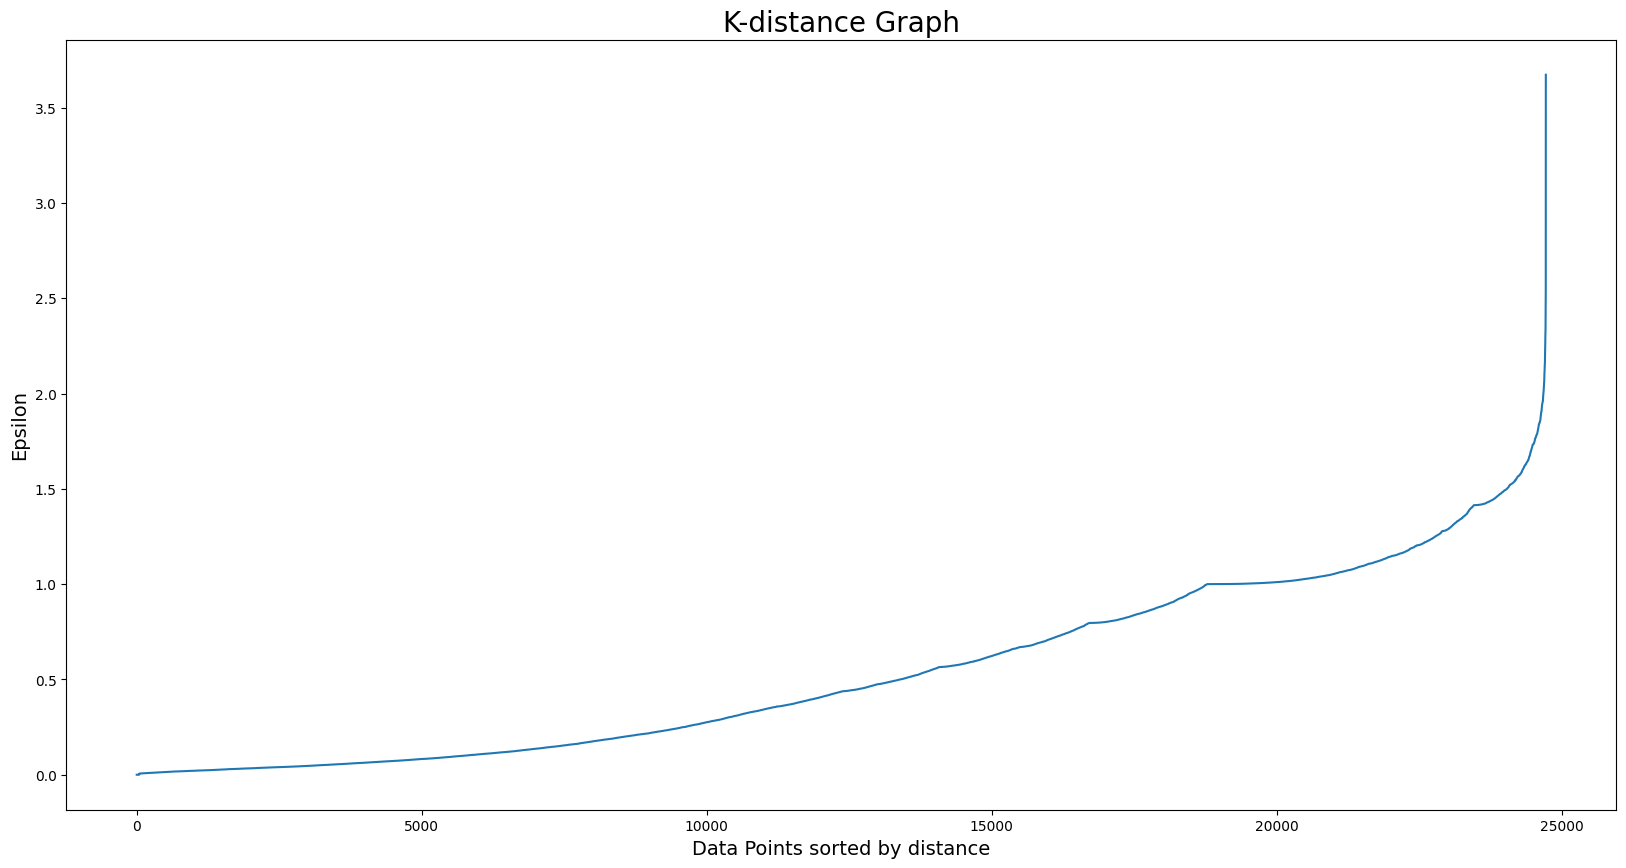

In [ ]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=4)
nbrs = neigh.fit(Train_X_transformed)
distances, indices = nbrs.kneighbors(Train_X_transformed)
# Plotting K-distance Graph
distances = np.sort(distances, axis=0)
distances = distances[:,3]
plt.figure(figsize=(20,10))
plt.plot(distances)
plt.title('K-distance Graph',fontsize=20)
plt.xlabel('Data Points sorted by distance',fontsize=14)
plt.ylabel('Epsilon',fontsize=14)
plt.show()

In [ ]:
distances.shape

(24725,)

In [16]:
# Example parameters, might need adjustment based on the dataset
dbscan = DBSCAN(eps=1.5, min_samples=4)
clusters = dbscan.fit_predict(Train_X_transformed)
feature_names = feature_transformer.get_feature_names_out()  # Replace with your actual feature names

# Add cluster labels to the original DataFrame
Train_X_df = pd.DataFrame(Train_X_transformed, columns=feature_names)
Train_X_df['cluster'] = clusters
Train_X_df['y'] = Train_y_transformed

In [ ]:
(Train_X_df['cluster'] != -1).sum(), Train_X_df.shape, Train_X_df.ndim

(24389, (24725, 25), 2)

In [19]:
# Filter out outliers
clustered_data = Train_X_df[Train_X_df['cluster'] != -1]

# Calculate means of each feature, average outcome, and count per cluster
cluster_summary = clustered_data.groupby('cluster').agg({**{col: 'mean' for col in Train_X_df.columns[:-2]}, 'y': 'mean', 'cluster': 'count'})
cluster_summary.rename(columns={'y': 'Percentage of class 1', 'cluster': 'Nr of Data Points in Cluster'}, inplace=True)

cluster_summary.T


cluster,0,1,2,3
num__log_campaign,0.085995,-0.297169,0.435563,1.900630
num__log_duration,-0.016647,0.021755,1.966733,-1.421493
num__log_previous,-0.517394,1.484528,2.457142,0.627504
cat__education_secondary,0.511661,0.550135,1.000000,0.000000
cat__education_tertiary,0.347109,0.329913,0.000000,1.000000
cat__loan_yes,0.173066,0.130215,0.000000,0.000000
cat__quarter_2nd quarter,0.231750,0.492093,1.000000,0.666667
cat__quarter_3rd quarter,0.514698,0.124832,0.000000,0.000000
cat__quarter_4th quarter,0.132552,0.196164,0.000000,0.000000
cat__age_group_30-45,0.532162,0.580417,0.000000,0.000000


In [28]:
clustered_data.cluster.value_counts()

cluster
0    18438
1     5944
2        4
3        3
Name: count, dtype: int64

**Remove the two smaller or minority clusters**

In [20]:
clustered_data = clustered_data[clustered_data.cluster.isin([0,1])]
clustered_data.cluster.value_counts()

cluster
0    18438
1     5944
Name: count, dtype: int64

## **Finding Best Model: Supervised Model + Imbalanced Data Solutions + Outlier removed (DBSCAN)**

Gradient Boosting + CTGAN	 is the best out-of-the-box performing model with an auprc score of $97\%$.

In [21]:
clustered_data.reset_index()
Train_X_outlier, Train_y_outlier = clustered_data.drop(columns =["y", "cluster"]).values, clustered_data["y"].values
Train_X_outlier.shape, Train_y_outlier.shape,


((24382, 23), (24382,))

In [31]:
# Setting up models
models = {
    'Naive Bayes': GaussianNB(),
    'Logistic Regression': LogisticRegression(class_weight='balanced', solver='saga', max_iter=200, random_state=42),
    'Decision Tree': DecisionTreeClassifier(class_weight='balanced', random_state=42),
    'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(scale_pos_weight=sum(Train_y_transformed == 0) / sum(Train_y_transformed == 1),random_state=42),  # XGBoost handles imbalance by scale_pos_weight
    'Extra Trees': ExtraTreesClassifier(class_weight='balanced', random_state=42),
    'AdaBoost': AdaBoostClassifier(estimator=DecisionTreeClassifier(class_weight='balanced',random_state=42)),
    'BaggingClassifier': BaggingClassifier(estimator=ExtraTreeClassifier(random_state=42), n_estimators=100)
}


results = {}
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

# 1. SMOTE
# smote = SMOTE(random_state=42)
Train_X_smote, Train_y_smote = apply_smote(Train_X_outlier, Train_y_outlier)

# 2. ADASYN
# adasyn = ADASYN(random_state=42)
Train_X_adasyn, Train_y_adasyn = apply_adasyn(Train_X_outlier, Train_y_outlier)

# 3. Random Undersampling
# undersampler = RandomUnderSampler(random_state=42)
Train_X_undersample, Train_y_undersample = apply_undersampling(Train_X_outlier, Train_y_outlier)

# 4. CTGAN
X_train_ctgan, y_train_ctgan = apply_ctgan(Train_X_outlier, Train_y_outlier)


#results = []

for name, model in models.items():

        cv_scores_ctgan = evaluate_model(model, X_train_ctgan, y_train_ctgan)
        results[f'{name} CTGAN'] = []
        results[f'{name} CTGAN'].append(cv_scores_ctgan.mean())
        #print(f'{name} + ctgan AUPRC Scores: {cv_scores_ctgan}')
        print(f'Mean AUPRC Score {name} + CTGAN: {cv_scores_ctgan.mean()}')

        cv_scores_smote = evaluate_model(model, Train_X_smote, Train_y_smote)
        results[f'{name} SMOTE'] = []
        results[f'{name} SMOTE'].append(cv_scores_smote.mean())
        #print(f'{name} + SMOTE AUPRC Scores: {cv_scores_smote}')
        print(f'Mean AUPRC Score {name} + SMOTE: {cv_scores_smote.mean()}')

        cv_scores_adasyn = evaluate_model(model, Train_X_adasyn, Train_y_adasyn)
        results[f'{name} ADASYN'] = []
        results[f'{name} ADASYN'].append(cv_scores_adasyn.mean())
        #print(f'{name} ADASYN AUPRC Scores: {cv_scores_adasyn}')
        print(f'Mean AUPRC Score {name} + ADASYN: {cv_scores_adasyn.mean()}')

        cv_scores_undersample = evaluate_model(model, Train_X_undersample, Train_y_undersample)
        results[f'{name} UNDERSAMPLE'] = []
        results[f'{name} UNDERSAMPLE'].append(cv_scores_undersample.mean())
        #print(f'{name} UNDERSAMPLE AUPRC Scores: {cv_scores_undersample}')
        print(f'Mean AUPRC Score {name} + UNDERSAMPLE: {cv_scores_undersample.mean()}')

        cv_scores = evaluate_model(model, Train_X_transformed, Train_y_transformed)
        results[f'{name} ORIGINAL'] = []
        results[f'{name} ORIGINAL'].append(cv_scores.mean())
        #print(f'{name} ORIGINAL AUPRC Scores: {cv_scores}')
        print(f'Mean AUPRC Score ORIGINAL {name}: {cv_scores.mean()}')

# Find and print the best model based on AUPRC
best_model = max(results, key=lambda x: x[1])
print(f"Best model based on AUPRC: {best_model} with an AUPRC of {results[best_model][0]:.4f}")

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Mean AUPRC Score Naive Bayes + CTGAN: 0.6856124938381605
Mean AUPRC Score Naive Bayes + SMOTE: 0.7680877450129646
Mean AUPRC Score Naive Bayes + ADASYN: 0.7371026154383588
Mean AUPRC Score Naive Bayes + UNDERSAMPLE: 0.7587540728833798
Mean AUPRC Score ORIGINAL Naive Bayes: 0.36924710592051807
Mean AUPRC Score Logistic Regression + CTGAN: 0.7960458742887163
Mean AUPRC Score Logistic Regression + SMOTE: 0.8376927821008554
Mean AUPRC Score Logistic Regression + ADASYN: 0.8040216172947714
Mean AUPRC Score Logistic Regression + UNDERSAMPLE: 0.8370671960945751
Mean AUPRC Score ORIGINAL Logistic Regression: 0.4872768761053688
Mean AUPRC Score Decision Tree + CTGAN: 0.8887172243226291
Mean AUPRC Score Decision Tree + SMOTE: 0.873183295767309
Mean AUPRC Score Decision Tree + ADASYN: 0.8647245436588255
Mean AUPRC Score Decision Tree + UNDERSAMPLE: 0.7816363149882387
Mean AUPRC Score ORIGINAL Decision Tree: 0.41533690628365544
Mean AUPRC Score Random Forest + CTGAN: 0.9637321054721403
Mean AUPRC 

In [ ]:
pd.DataFrame(results).rename(index = {0 : 'Mean AUCPR'}).T.sort_values(by = 'Mean AUCPR', ascending = False)

,Mean AUCPR
Gradient Boosting CTGAN,0.970031
XGBoost CTGAN,0.968012
Random Forest CTGAN,0.964106
BaggingClassifier CTGAN,0.961976
XGBoost SMOTE,0.960719
XGBoost ADASYN,0.957760
Extra Trees CTGAN,0.953428
Random Forest SMOTE,0.937565
AdaBoost CTGAN,0.933320
BaggingClassifier SMOTE,0.932467


## **Finding Best Model: Supervised Model + Imbalanced Data Solutions + Outlier removed (DBSCAN) + PCA**

XGBoost + CTGAN + PCA	 is the best out-of-the-box performing model with an auprc score of $95.8\%$.

In [22]:
pca = PCA().fit(Train_X_outlier)
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
optimal_num_components = np.argmax(cumulative_variance >= 0.95) + 1  # Adjust the threshold as necessary
print(f"Optimal number of components by 95% variance: {optimal_num_components}")


Optimal number of components by 95% variance: 13


In [23]:
pca_optimal = PCA(n_components=optimal_num_components)
Train_X_pca = pca_optimal.fit_transform(Train_X_outlier)



In [34]:

# Setting up models
models = {
    'Naive Bayes': GaussianNB(),
    'Logistic Regression': LogisticRegression(class_weight='balanced', solver='saga', max_iter=200, random_state=42),
    'Decision Tree': DecisionTreeClassifier(class_weight='balanced', random_state=42),
    'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(scale_pos_weight=sum(Train_y_transformed == 0) / sum(Train_y_transformed == 1),random_state=42),  # XGBoost handles imbalance by scale_pos_weight
    'Extra Trees': ExtraTreesClassifier(class_weight='balanced', random_state=42),
    'AdaBoost': AdaBoostClassifier(estimator=DecisionTreeClassifier(class_weight='balanced',random_state=42)),
    'BaggingClassifier': BaggingClassifier(estimator=ExtraTreeClassifier(random_state=42), n_estimators=100)
}


results = {}
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

# 1. SMOTE
# smote = SMOTE(random_state=42)
Train_X_smote, Train_y_smote = apply_smote(Train_X_pca, Train_y_outlier)

# 2. ADASYN
# adasyn = ADASYN(random_state=42)
Train_X_adasyn, Train_y_adasyn = apply_adasyn(Train_X_pca, Train_y_outlier)

# 3. Random Undersampling
# undersampler = RandomUnderSampler(random_state=42)
Train_X_undersample, Train_y_undersample = apply_undersampling(Train_X_pca, Train_y_outlier)

# 4. CTGAN
X_train_ctgan, y_train_ctgan = apply_ctgan(Train_X_pca, Train_y_outlier)


#results = []

for name, model in models.items():

        cv_scores_ctgan = evaluate_model(model, X_train_ctgan, y_train_ctgan)
        results[f'{name} CTGAN'] = []
        results[f'{name} CTGAN'].append(cv_scores_ctgan.mean())
        #print(f'{name} + ctgan AUPRC Scores: {cv_scores_ctgan}')
        print(f'Mean AUPRC Score {name} + CTGAN: {cv_scores_ctgan.mean()}')

        cv_scores_smote = evaluate_model(model, Train_X_smote, Train_y_smote)
        results[f'{name} SMOTE'] = []
        results[f'{name} SMOTE'].append(cv_scores_smote.mean())
        #print(f'{name} + SMOTE AUPRC Scores: {cv_scores_smote}')
        print(f'Mean AUPRC Score {name} + SMOTE: {cv_scores_smote.mean()}')

        cv_scores_adasyn = evaluate_model(model, Train_X_adasyn, Train_y_adasyn)
        results[f'{name} ADASYN'] = []
        results[f'{name} ADASYN'].append(cv_scores_adasyn.mean())
        #print(f'{name} ADASYN AUPRC Scores: {cv_scores_adasyn}')
        print(f'Mean AUPRC Score {name} + ADASYN: {cv_scores_adasyn.mean()}')

        cv_scores_undersample = evaluate_model(model, Train_X_undersample, Train_y_undersample)
        results[f'{name} UNDERSAMPLE'] = []
        results[f'{name} UNDERSAMPLE'].append(cv_scores_undersample.mean())
        #print(f'{name} UNDERSAMPLE AUPRC Scores: {cv_scores_undersample}')
        print(f'Mean AUPRC Score {name} + UNDERSAMPLE: {cv_scores_undersample.mean()}')

        cv_scores = evaluate_model(model, Train_X_pca, Train_y_outlier)
        results[f'{name} ORIGINAL'] = []
        results[f'{name} ORIGINAL'].append(cv_scores.mean())
        #print(f'{name} ORIGINAL AUPRC Scores: {cv_scores}')
        print(f'Mean AUPRC Score ORIGINAL {name}: {cv_scores.mean()}')

# Find and print the best model based on AUPRC
best_model = max(results, key=lambda x: x[1])
print(f"Best model based on AUPRC: {best_model} with an AUPRC of {results[best_model][0]:.4f}")

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Mean AUPRC Score Naive Bayes + CTGAN: 0.7175517086273517
Mean AUPRC Score Naive Bayes + SMOTE: 0.8057945687042191
Mean AUPRC Score Naive Bayes + ADASYN: 0.7737463570886255
Mean AUPRC Score Naive Bayes + UNDERSAMPLE: 0.8052868770115946
Mean AUPRC Score ORIGINAL Naive Bayes: 0.4356744923942542
Mean AUPRC Score Logistic Regression + CTGAN: 0.7203259591811072
Mean AUPRC Score Logistic Regression + SMOTE: 0.8310808922098835
Mean AUPRC Score Logistic Regression + ADASYN: 0.797685691801184
Mean AUPRC Score Logistic Regression + UNDERSAMPLE: 0.8300463308718969
Mean AUPRC Score ORIGINAL Logistic Regression: 0.4784476818222905
Mean AUPRC Score Decision Tree + CTGAN: 0.8565758813916468
Mean AUPRC Score Decision Tree + SMOTE: 0.8691924810936708
Mean AUPRC Score Decision Tree + ADASYN: 0.8616792362638898
Mean AUPRC Score Decision Tree + UNDERSAMPLE: 0.7878972065999195
Mean AUPRC Score ORIGINAL Decision Tree: 0.41024947352453744
Mean AUPRC Score Random Forest + CTGAN: 0.9468920947311005
Mean AUPRC S

In [37]:
pd.DataFrame(results).rename(index = {0 : 'Mean AUCPR'}).T.sort_values(by = 'Mean AUCPR', ascending = False)

,Mean AUCPR
XGBoost CTGAN,0.959327
Random Forest CTGAN,0.946892
BaggingClassifier CTGAN,0.939816
Gradient Boosting CTGAN,0.929620
BaggingClassifier SMOTE,0.910753
XGBoost SMOTE,0.907040
Random Forest SMOTE,0.906604
Extra Trees SMOTE,0.897910
BaggingClassifier ADASYN,0.888109
XGBoost ADASYN,0.887491


### **Hyperparameter Tunning with Hyperopt for XGBoost + CTGAN + PCA + DBSCAN**

The new performance after hyperparameter fine tunning is $96.4\%$ which is close the $97\%$ best performing model we earlier saw

In [24]:
X_train_ctgan, y_train_ctgan = apply_ctgan(Train_X_pca, Train_y_outlier)

# Calculate the proportion of classes
neg_class_count = np.sum(y_train_ctgan == 0)
pos_class_count = np.sum(y_train_ctgan == 1)
scale_pos_weight = neg_class_count / pos_class_count


# Custom AUPRC evaluation metric for XGBoost
def auprc_eval(preds, dtrain):
    labels = dtrain.get_label()
    precision, recall, _ = precision_recall_curve(labels, preds)
    score = auc(recall, precision)
    return 'AUPRC', score

# Base XGBoost model setup
xgb_base_params = {
    'random_state': 42,
    'use_label_encoder': False,
    'eval_metric': 'logloss',
    'scale_pos_weight': scale_pos_weight
}

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Hyperparameter tuning using Hyperopt
def objective(params):
    model = xgb.XGBClassifier(
        **xgb_base_params,
        n_estimators=int(params['n_estimators']),
        max_depth=int(params['max_depth']),
        learning_rate=params['learning_rate'],
        subsample=params['subsample'],
        colsample_bytree=params['colsample_bytree']
    )
    score = cross_val_score(model,
                            X_train_ctgan,
                            y_train_ctgan,
                            cv=skf, scoring='average_precision').mean()
    return {'loss': -score, 'status': STATUS_OK}

param_space = {
    'n_estimators': hp.quniform('n_estimators', 50, 300, 10),
    'max_depth': hp.quniform('max_depth', 3, 15, 1),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'subsample': hp.uniform('subsample', 0.7, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.7, 1.0)
}

trials = Trials()
best_params = fmin(fn=objective,
                   space=param_space,
                   algo=tpe.suggest,
                   max_evals=15,
                   trials=trials)

best_params['n_estimators'] = int(best_params['n_estimators'])
best_params['max_depth'] = int(best_params['max_depth'])
print(f'Best Hyperparameters: {best_params}')

# Final model with best hyperparameters
final_model = xgb.XGBClassifier(**xgb_base_params, **best_params)

# Evaluate final model using stratified cross-validation
final_cv_scores = evaluate_model(final_model, X_train_ctgan, y_train_ctgan)
print(f'Final Model 10-Fold Cross-Validation AUPRC Scores: {final_cv_scores}')
print(f'Mean AUPRC Score: {final_cv_scores.mean()}')

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


100%|██████████| 15/15 [02:36<00:00, 10.41s/trial, best loss: -0.9633919856187464]
Best Hyperparameters: {'colsample_bytree': 0.9435998332592168, 'learning_rate': 0.04728858007458842, 'max_depth': 9, 'n_estimators': 270, 'subsample': 0.7803198519104928}
Final Model 10-Fold Cross-Validation AUPRC Scores: [0.96025561 0.96554215 0.96437002]
Mean AUPRC Score: 0.963389258987989


### Feature importances after PCA and Outlier removal for final XGBoost Model

Feature Importances:
Feature: f0, Importance: 28.400381088256836
Feature: f1, Importance: 27.47539710998535
Feature: f2, Importance: 44.533897399902344
Feature: f3, Importance: 27.670879364013672
Feature: f4, Importance: 27.032255172729492
Feature: f5, Importance: 37.821502685546875
Feature: f6, Importance: 15.434064865112305
Feature: f7, Importance: 18.44350814819336
Feature: f8, Importance: 13.63507080078125
Feature: f9, Importance: 22.848312377929688
Feature: f10, Importance: 23.665393829345703
Feature: f11, Importance: 20.13503646850586
Feature: f12, Importance: 25.913644790649414


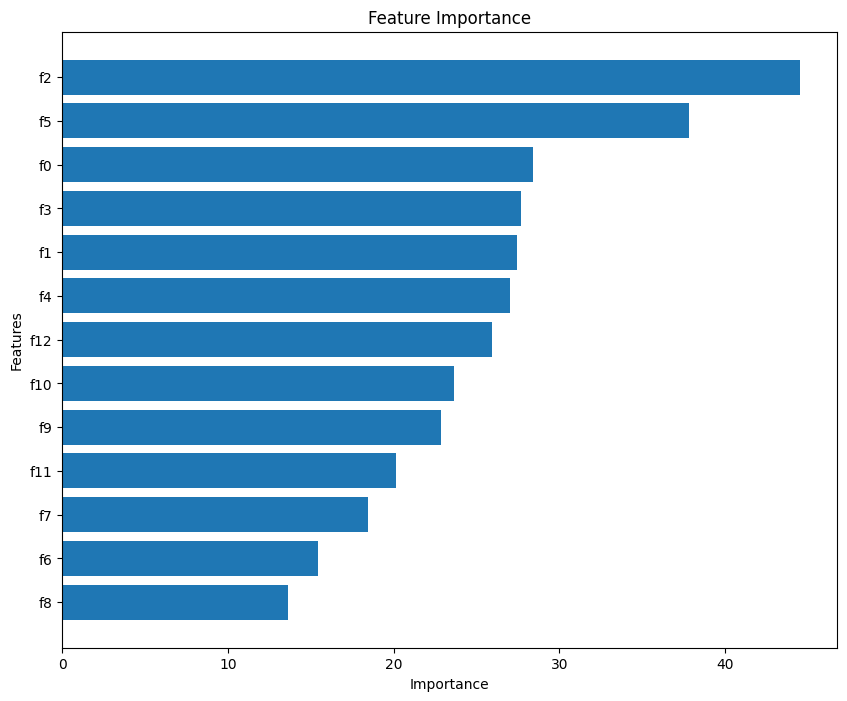

In [36]:
final_model.fit(X_train_ctgan, y_train_ctgan)

feature_importances = final_model.get_booster().get_score(importance_type='gain')  # You can also use 'weight' or 'cover'
#feature_names = feature_transformer.get_feature_names_out()

# Print the feature importance
print("Feature Importances:")
for feature, importance in feature_importances.items():
    print(f"Feature: {feature}, Importance: {importance}")

import matplotlib.pyplot as plt

# Sorting the features based on importance
sorted_importances = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)
features, importances = zip(*sorted_importances)

# Creating a bar chart
plt.figure(figsize=(10, 8))
plt.barh(features, importances)
plt.xlabel("Importance")
plt.ylabel("Features")
plt.title("Feature Importance")
plt.gca().invert_yaxis()  # Invert the Y-axis to show the most important feature at the top
plt.show()


## **Other Unsupervised anomaly detection techniques**

In [ ]:
# lof = LocalOutlierFactor(novelty=False)
# mask_lof = lof.fit(Train_X_transformed)

## **Saving Model**

In [ ]:
# Save the model
joblib.dump(final_model, 'final_xgb_model.pkl')

['final_xgb_model.pkl']

In [ ]:
import numpy as np

# Assuming Test_X_transformed and Test_y_transformed are your numpy arrays
np.save('Test_X_transformed.npy', X_train_ctgan)
# np.save('Test_y_transformed.npy', y_train_ctgan)

In [ ]:
from google.colab import files
for data_f in ["final_xgb_model.pkl", 'Test_X_transformed.npy', 'Test_y_transformed.npy']:
  files.download( data_f)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **AI Explainability**

The feature importance or coefficients tell us how much the model output changes when we change each of the input feature but the magnitude of a coefficient is not necessarily a good measure of a feature's importance. As we can see in the figures just above ad below, the different compoents have different weights. The explainiability in terms of the original features has been carried out as well

### **Global Explainability**

#### **In terms of  PCA components**


In [ ]:
feature_names = feature_transformer.get_feature_names_out().tolist()
components = pca_optimal.components_
# Create the SHAP explainer object
# final_model.fit(X_train_ctgan, y_train_ctgan) #already trained above
explainer = shap.TreeExplainer(final_model)

shap_values = explainer(X_train_ctgan)


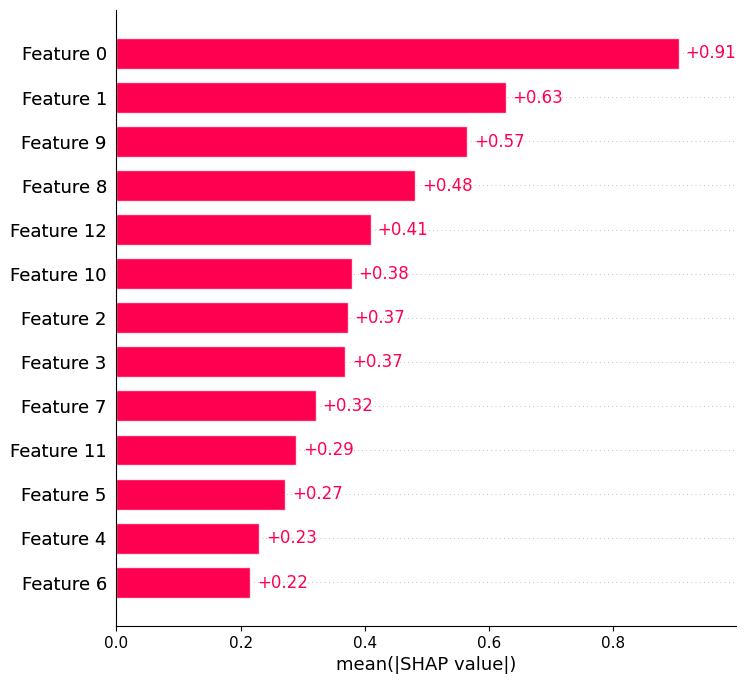

In [ ]:
shap.plots.bar(shap_values, max_display=19)

#### **In terms of the original features**
 A closer look at the PCA components for component $0$ and $1$, the domininnt features are: campaign, duration and previous which can also be seen below as the dominant global features.

In [ ]:
# this is the original data before PCA. this data has been filtered of ourliers and CTGAN applied
X_train_ctgan_orig, y_train_ctgan_orig = apply_ctgan(Train_X_outlier, Train_y_outlier)

# explainer = shap.TreeExplainer(final_model, X_train_ctgan)
explainer = shap.Explainer(final_model, X_train_ctgan)

shap_values2 = explainer(X_train_ctgan)

original_feature_shap_values = shap_values2.values @ components


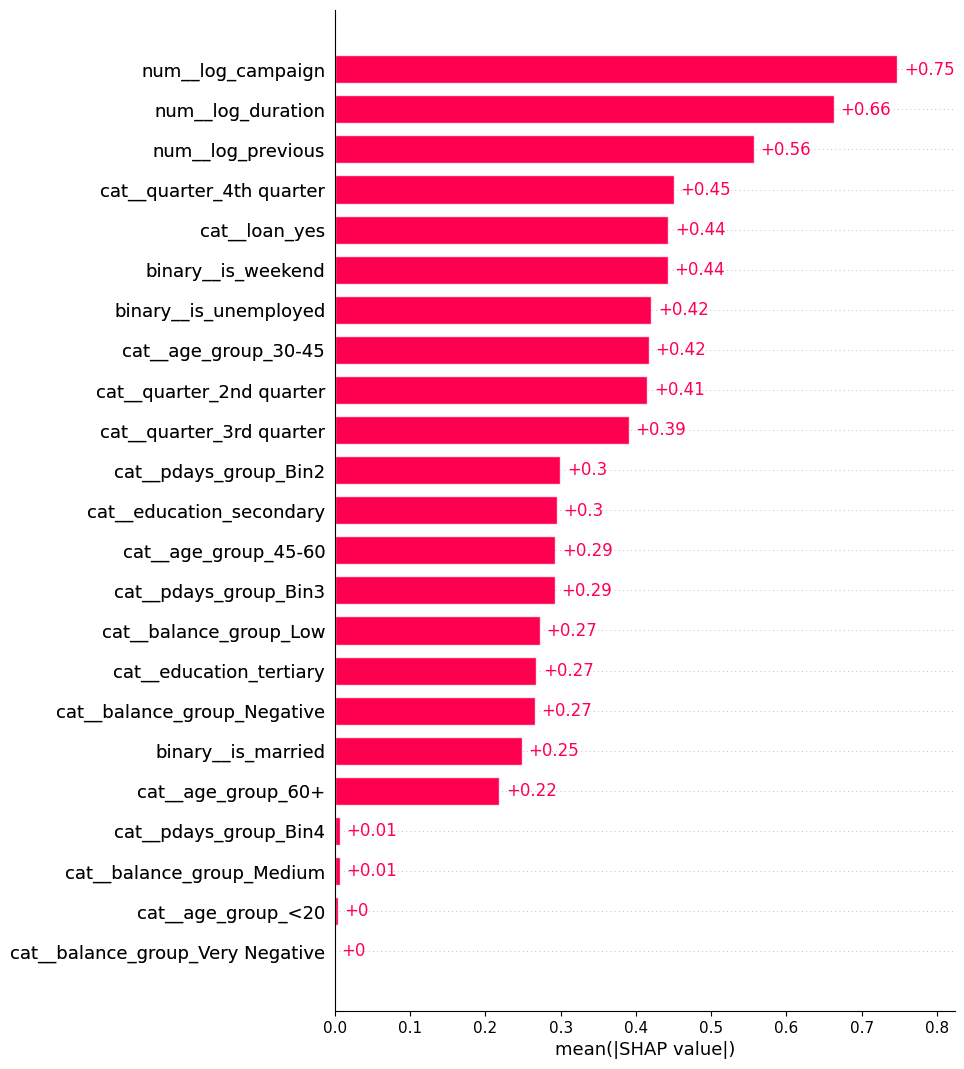

In [ ]:
# Create a SHAP explanation object with original features
shap_values_orig_exp = shap.Explanation(
    values=original_feature_shap_values,
    base_values=shap_values2.base_values,
    data=X_train_ctgan_orig,
    feature_names=feature_names)


#plots importance of each feature
shap.plots.bar(shap_values_orig_exp, max_display=23)

###**Local Explainability**

#### **In terms of  PCA components**


In [ ]:
y_train_ctgan_orig[3], y_train_ctgan_orig[5]

(0, 1)

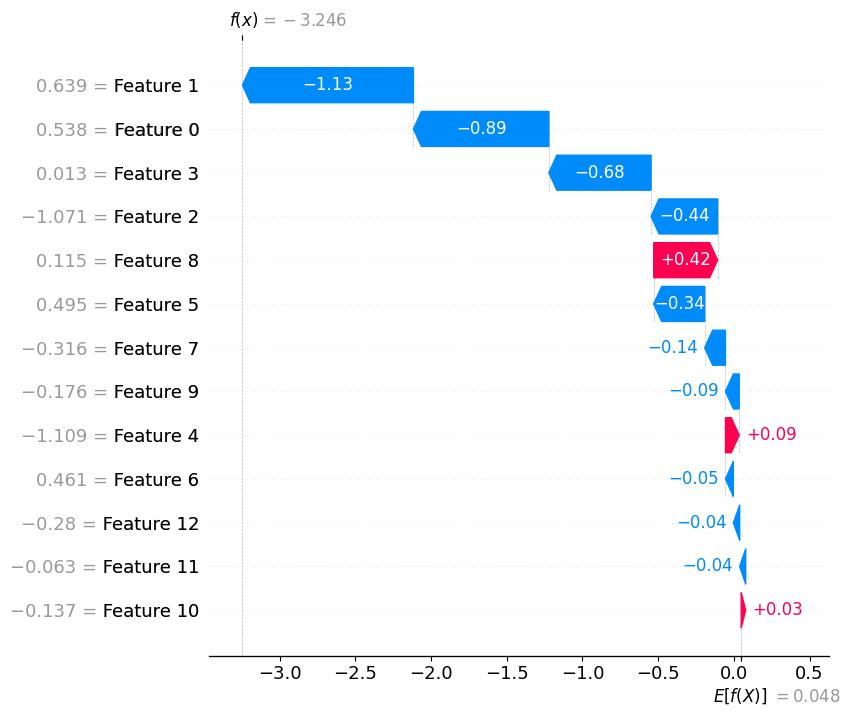

In [ ]:
# in terms of PCA components. Negative class
shap.plots.waterfall(shap_values[3], max_display=13)

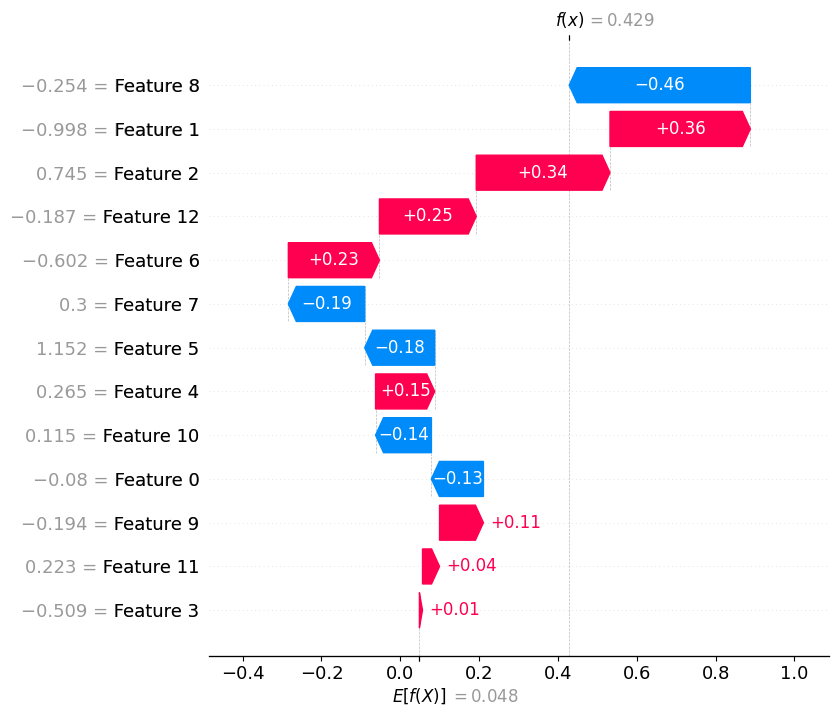

In [ ]:
# in terms of PCA components. Positive class
shap.plots.waterfall(shap_values[5], max_display=13)

#### **In terms of the original features**


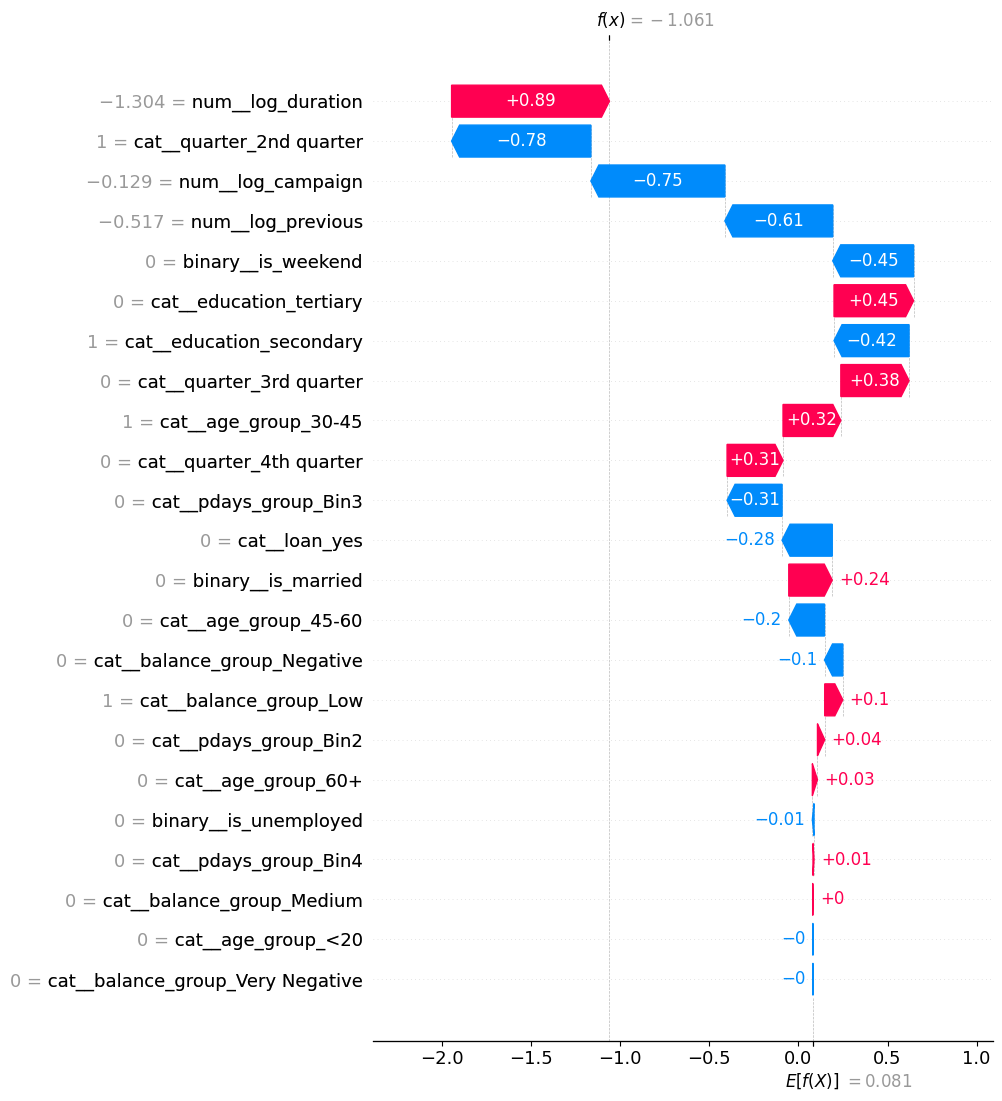

In [ ]:
# Select the instance index. Negative class
instance_index = 3

# Force plot for a single instance
shap.force_plot(
    shap_values_orig_exp.base_values[instance_index],
    shap_values_orig_exp.values[instance_index],
    shap_values_orig_exp.data[instance_index, :],
    feature_names=shap_values_orig_exp.feature_names
)

shap.plots.waterfall(shap_values_orig_exp[instance_index ], max_display=23)

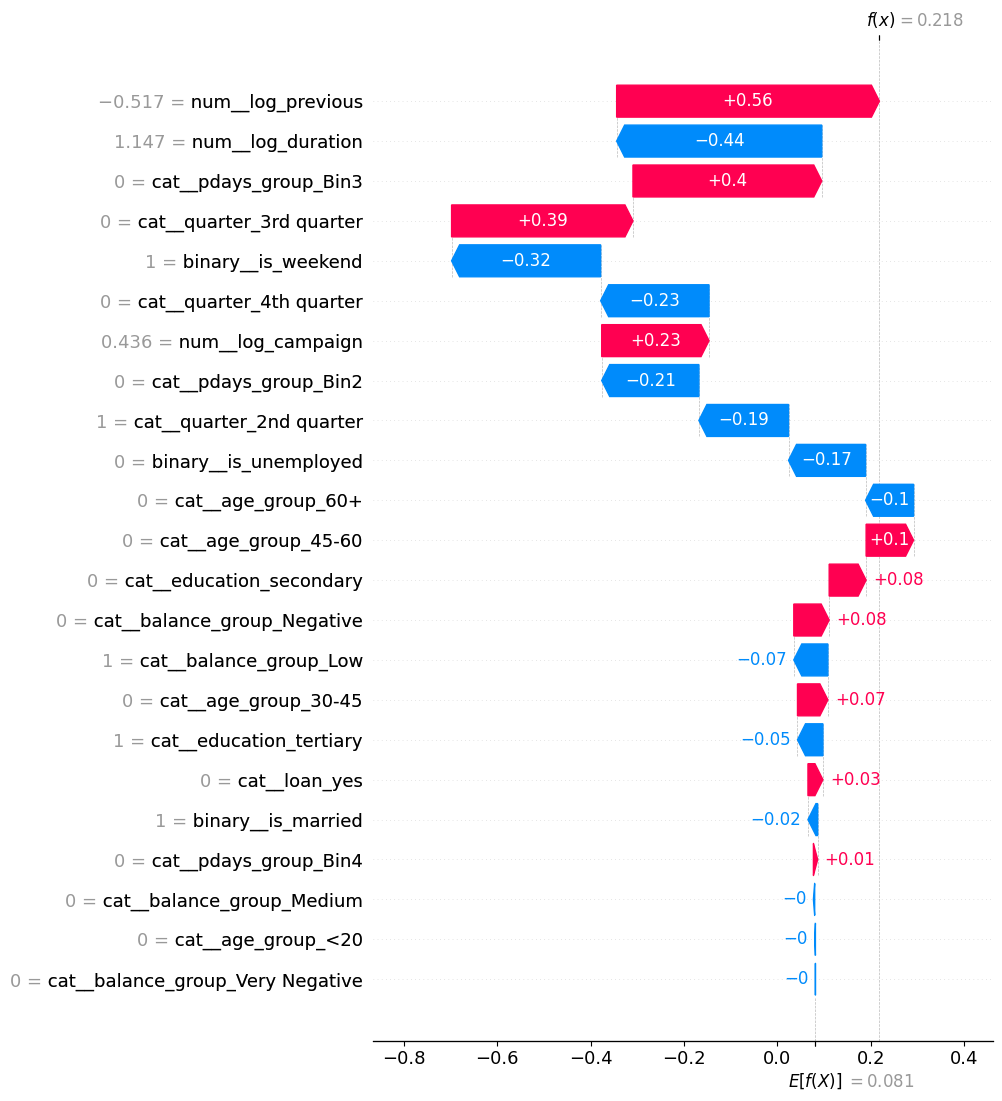

In [ ]:
# Select the instance index. Positiive class
instance_index = 5

# Force plot for a single instance
shap.force_plot(
    shap_values_orig_exp.base_values[instance_index],
    shap_values_orig_exp.values[instance_index],
    shap_values_orig_exp.data[instance_index, :],
    feature_names=shap_values_orig_exp.feature_names
)

shap.plots.waterfall(shap_values_orig_exp[instance_index], max_display=23)

##**AI FAIRNESS**

In [25]:
# best_X_train, best_y_train = X_train_ctgan, y_train_ctgan # dat used in the final training

# best_X_train, best_y_train = apply_ctgan(Train_X_outlier, Train_y_outlier)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


In [43]:
best_X_train2, best_y_train2 = Train_X_transformed, Train_y_transformed


In [51]:

feature_names = feature_transformer.get_feature_names_out().tolist()

# convert daataframe
best_X_train_df = pd.DataFrame(best_X_train2, columns=feature_names)

sensitive_features_names = ['binary__is_married']#,'cat__age_group_30-45', 'cat__age_group_45-60', 'cat__age_group_60+', 'cat__age_group_<20']

# Extract sensitive features from the subset
sensitive_features_data = best_X_train_df[sensitive_features_names]


In [45]:
# Fit the final model on the subset of data
final_model2 = xgb.XGBClassifier(**xgb_base_params)
final_model2.fit(best_X_train2, best_y_train2)
y_pred2 = final_model2.predict(best_X_train2)


In [31]:
# Fit the final model on the subset of data
# final_model = xgb.XGBClassifier(**xgb_base_params)
# final_model.fit(best_X_train, best_y_train)
# y_pred = final_model.predict(best_X_train)


In [52]:
metrics = {
    "accuracy": accuracy_score,
    "precision": precision_score,
    'average_precision': average_precision_score,
    "false positive rate": false_positive_rate,
    "false negative rate": false_negative_rate,
    'true_positive_rate': true_positive_rate,
    "selection rate": selection_rate,
    "count": count,
    }



# Setup MetricFrame for evaluation with simple metrics
metric_frame = MetricFrame(
    metrics=metrics,
    y_true=best_y_train2,
    y_pred=y_pred2,
    sensitive_features=sensitive_features_data
)



# Print metric results
print("Overall metrics:")
print(metric_frame.overall)

Overall metrics:
accuracy                   0.901234
precision                  0.693634
average_precision          0.463357
false positive rate        0.043760
false negative rate        0.420499
true_positive_rate         0.579501
selection rate             0.121982
count                  24725.000000
dtype: float64


In [53]:
# Print metric results
print("Overall metrics:")
metric_frame.by_group

Overall metrics:


,accuracy,precision,average_precision,false positive rate,false negative rate,true_positive_rate,selection rate,count
binary__is_married,,,,,,,,
0.0,0.883876,0.687290,0.477481,0.055903,0.406849,0.593151,0.148093,10041.0
1.0,0.913103,0.699804,0.452454,0.035868,0.432962,0.567038,0.104127,14684.0


Both married or unmarried have equal opportunities beacuse the true positive rates are the same

In [56]:
# Apply fairness constraint using Exponentiated Gradient method
mitigator = ExponentiatedGradient(estimator=xgb.XGBClassifier(),
                                  constraints=DemographicParity())

mitigator.fit(best_X_train2, best_y_train2,
              sensitive_features=sensitive_features_data)

# Evaluate the mitigated model
metrics = {
    "accuracy": accuracy_score,
    "precision": precision_score,
    'average_precision': average_precision_score,
    "false positive rate": false_positive_rate,
    "false negative rate": false_negative_rate,
    'true_positive_rate': true_positive_rate,
    "selection rate": selection_rate,
    "count": count,
    }

metric_frame_mitigated = MetricFrame(
    metrics=metrics,
    y_true=best_y_train2,
    y_pred=mitigator.predict(best_X_train2),
    sensitive_features=sensitive_features_data
)

print("Mitigated metrics by group:")
pd.DataFrame(metric_frame_mitigated.by_group)

Mitigated metrics by group:


,accuracy,precision,average_precision,false positive rate,false negative rate,true_positive_rate,selection rate,count
binary__is_married,,,,,,,,
0.0,0.884872,0.773385,0.451709,0.028252,0.534533,0.465467,0.103277,10041.0
1.0,0.918006,0.765346,0.460932,0.023599,0.478007,0.521993,0.087646,14684.0


Using a demographic parity constraint worsen the trrue positve rate

In [57]:
# Apply fairness constraint using Exponentiated Gradient method
mitigator = ExponentiatedGradient(estimator=xgb.XGBClassifier(),
                                  constraints=EqualizedOdds())

mitigator.fit(best_X_train2, best_y_train2,
              sensitive_features=sensitive_features_data)

# Evaluate the mitigated model
metrics = {
    "accuracy": accuracy_score,
    "precision": precision_score,
    'average_precision': average_precision_score,
    "false positive rate": false_positive_rate,
    "false negative rate": false_negative_rate,
    'true_positive_rate': true_positive_rate,
    "selection rate": selection_rate,
    "count": count,
    }

metric_frame_mitigated = MetricFrame(
    metrics=metrics,
    y_true=best_y_train2,
    y_pred=mitigator.predict(best_X_train2),
    sensitive_features=sensitive_features_data
)

print("Mitigated metrics by group:")
pd.DataFrame(metric_frame_mitigated.by_group)

Mitigated metrics by group:


,accuracy,precision,average_precision,false positive rate,false negative rate,true_positive_rate,selection rate,count
binary__is_married,,,,,,,,
0.0,0.889354,0.764249,0.476006,0.032820,0.486361,0.513639,0.115327,10041.0
1.0,0.919845,0.807626,0.463928,0.017348,0.506094,0.493906,0.078589,14684.0


In [58]:
# Apply fairness constraint using Exponentiated Gradient method
mitigator = ExponentiatedGradient(estimator=xgb.XGBClassifier(),
                                  constraints=TruePositiveRateParity())

mitigator.fit(best_X_train2, best_y_train2,
              sensitive_features=sensitive_features_data)

# Evaluate the mitigated model
metrics = {
    "accuracy": accuracy_score,
    "precision": precision_score,
    'average_precision': average_precision_score,
    "false positive rate": false_positive_rate,
    "false negative rate": false_negative_rate,
    'true_positive_rate': true_positive_rate,
    "selection rate": selection_rate,
    "count": count,
    }

metric_frame_mitigated = MetricFrame(
    metrics=metrics,
    y_true=best_y_train2,
    y_pred=mitigator.predict(best_X_train2),
    sensitive_features=sensitive_features_data
)

print("Mitigated metrics by group:")
pd.DataFrame(metric_frame_mitigated.by_group)

Mitigated metrics by group:


,accuracy,precision,average_precision,false positive rate,false negative rate,true_positive_rate,selection rate,count
binary__is_married,,,,,,,,
0.0,0.889354,0.764249,0.476006,0.032820,0.486361,0.513639,0.115327,10041.0
1.0,0.919845,0.807626,0.463928,0.017348,0.506094,0.493906,0.078589,14684.0


Both EqualizedOdd and TruePositiveRate parity constraints have equal effects of producning equal opportunities across the different classes but the performnce is still worse than before using the constraints

In [60]:
# Apply ThresholdOptimizer for post-processing
postprocess_est = ThresholdOptimizer(
    estimator=xgb.XGBClassifier(),
    constraints="demographic_parity",
    predict_method='predict_proba'
)

postprocess_est.fit(best_X_train2, best_y_train2, sensitive_features=sensitive_features_data)

# Evaluate the post-processed model
postprocessed_predictions = postprocess_est.predict(best_X_train2, sensitive_features=sensitive_features_data)



# Evaluate the mitigated model
metrics = {
    "accuracy": accuracy_score,
    "precision": precision_score,
    'average_precision': average_precision_score,
    "false positive rate": false_positive_rate,
    "false negative rate": false_negative_rate,
    'true_positive_rate': true_positive_rate,
    "selection rate": selection_rate,
    "count": count,
    }

metric_frame_postprocessed = MetricFrame(
    metrics=metrics,
    y_true=best_y_train2,
    y_pred=mitigator.predict(best_X_train2),
    sensitive_features=sensitive_features_data
)

print("Post-processed metrics by group:")
pd.DataFrame(metric_frame_postprocessed.by_group)

Post-processed metrics by group:


,accuracy,precision,average_precision,false positive rate,false negative rate,true_positive_rate,selection rate,count
binary__is_married,,,,,,,,
0.0,0.889055,0.762726,0.474881,0.033061,0.486941,0.513059,0.115427,10041.0
1.0,0.919981,0.809565,0.464525,0.017113,0.506624,0.493376,0.078317,14684.0


In [61]:
# Compute sample weights
sample_weights = compute_sample_weight(class_weight='balanced', y=best_y_train2)

# Fit the final model on the reweighed data
final_model_reweighed = xgb.XGBClassifier(**xgb_base_params)
final_model_reweighed.fit(best_X_train2, best_y_train2, sample_weight=sample_weights)

# Apply ThresholdOptimizer for post-processing on the reweighed model
postprocess_est_reweighed = ThresholdOptimizer(
    estimator=final_model_reweighed,
    constraints="demographic_parity",
    predict_method='predict_proba'
)

postprocess_est_reweighed.fit(best_X_train2, best_y_train2, sensitive_features=sensitive_features_data)

# Evaluate the post-processed model
postprocessed_predictions_reweighed = postprocess_est_reweighed.predict(best_X_train2, sensitive_features=sensitive_features_data)

metric_frame_postprocessed_reweighed = MetricFrame(
    metrics={
        'accuracy': accuracy_score,
        'precision': lambda y_true, y_pred: precision_score(y_true, y_pred, zero_division=1),
        'average_precision': lambda y_true, y_pred: average_precision_score(y_true, y_pred),
        'true_positive_rate': true_positive_rate
    },
    y_true=best_y_train2,
    y_pred=postprocessed_predictions_reweighed,
    sensitive_features=sensitive_features_data
)

print("Post-processed metrics by group after reweighing:")
print(pd.DataFrame(metric_frame_postprocessed_reweighed.by_group))

Post-processed metrics by group after reweighing:
                    accuracy  precision  average_precision  true_positive_rate
binary__is_married                                                            
0.0                 0.885669   0.778316           0.454709            0.466628
1.0                 0.913035   0.699607           0.452040            0.566508


In [65]:
# Fit the final model on the original data
final_model = xgb.XGBClassifier(**xgb_base_params, **best_params)
final_model.fit(best_X_train2, best_y_train2)

# Predict probabilities
y_pred_proba = final_model.predict_proba(best_X_train2)[:, 1]

# Function to adjust thresholds for each group
def adjust_thresholds(y_true, y_pred_proba, sensitive_features, thresholds):
    adjusted_preds = np.zeros_like(y_true)
    for group in np.unique(sensitive_features):
        group_indices = sensitive_features == group
        adjusted_preds[group_indices] = (y_pred_proba[group_indices] >= thresholds[group]).astype(int)
    return adjusted_preds

# Evaluate initial metrics
metric_frame_initial = MetricFrame(
    metrics={
        'average_precision': lambda y_true, y_pred: average_precision_score(y_true, y_pred),
        'true_positive_rate': true_positive_rate
    },
    y_true=best_y_train2,
    y_pred=(y_pred_proba >= 0.5).astype(int),
    sensitive_features=sensitive_features_data
)


# Manually adjust thresholds based on initial TPR and TNR
thresholds = {
    0: 0.3,  # Threshold for group 0 (not married)
    1: 0.3   # Threshold for group 1 (married)
}

# Get adjusted predictions
y_pred_adjusted = adjust_thresholds(best_y_train2, y_pred_proba, sensitive_features_data['binary__is_married'], thresholds)

# Evaluate adjusted metrics
metric_frame_adjusted = MetricFrame(
    metrics={
        'average_precision': lambda y_true, y_pred: average_precision_score(y_true, y_pred),
        'true_positive_rate': true_positive_rate
    },
    y_true=best_y_train2,
    y_pred=y_pred_adjusted,
    sensitive_features=sensitive_features_data
)

print("Adjusted metrics by group Initial + After Postprocessing:")
pd.concat([pd.DataFrame(metric_frame_initial.by_group), pd.DataFrame(metric_frame_adjusted.by_group)], axis = 1)

Adjusted metrics by group Initial + After Postprocessing:


,average_precision,true_positive_rate,average_precision,true_positive_rate
binary__is_married,,,,
0.0,0.603782,0.681950,0.553918,0.876959
1.0,0.594273,0.659777,0.535812,0.846317


By adjusting the poost-processing threshoolds, we have increased the true-positive rate significantly

### **DEPLOYMENT**

In [ ]:
import streamlit as st
import pandas as pd
import numpy as np
import joblib

model = joblib.load("final_xgb_model.pkl")

Test_X = np.load("Test_X_transformed.npy")
Test_y = np.load("Test_y_transformed.npy")

Test_df = pd.DataFrame(
    Test_X, columns=[f"PCA_{str(t)}" for t in range(1, Test_X.shape[1] + 1)]
)

Test_df["target"] = Test_y


def highlight_columns(col):
    color = "skyblue" if col.name in ["target", "Predicted target"] else "green"
    return ["background-color: {}".format(color) for _ in col]


def run():

    add_selectbox = st.sidebar.selectbox(
        "How would you like to see the app work?", ("Example", "Batch")
    )

    st.sidebar.info("This app is created to predict patient hospital charges")
    # st.sidebar.success("")

    # st.sidebar.image(image_hospital)

    st.title("XGBoost Classification of Subscribers")

    if add_selectbox == "Example":
        if st.button("Random Example"):
            st.write("Selecting random examples from the test data")
            samples = Test_df.sample(20)
            st.session_state.samples = samples
            st.dataframe(samples.style.apply(highlight_columns, axis=0))

        if "samples" in st.session_state and st.button("Predict"):
            input = st.session_state.samples.drop("target", axis=1)
            output = model.predict(input)
            st.session_state.samples["Predicted target"] = output

            st.dataframe(
                st.session_state.samples.style.apply(highlight_columns, axis=0)
            )

            # st.dataframe(
            #     st.session_state.samples.drop("target", axis=1).style.apply(
            #         highlight_columns, axis=0
            #     )
            # )

    if add_selectbox == "Batch":

        file_upload = st.file_uploader("Upload csv file for predictions", type=["csv"])

        if file_upload is not None:
            sample_data = pd.read_csv(file_upload, index_col=0)
            st.session_state.sample_data = sample_data
            st.dataframe(sample_data.style.apply(highlight_columns, axis=0))

        if "sample_data" in st.session_state and st.button("Predict"):
            input = st.session_state.sample_data.drop("target", axis=1)

            output = model.predict(input)
            st.session_state.sample_data["Predicted target"] = output

            st.dataframe(
                st.session_state.sample_data.style.apply(highlight_columns, axis=0)
            )


if __name__ == "__main__":
    run()
